In [16]:
import joblib
import numpy as np
import joblib
import numpy as np
import networkx as nx
import yaml
import utilities as ut 
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

import opt_tools as optools


In [17]:
experiment = 'lilucas'

In [ ]:
experiment = 'lilucas'

config_files = {
                    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
                    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
                    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
                }
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']
hyperparams_baryca = configs['hyperparams_baryca']

all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

In [19]:
all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'


In [16]:
# --- DIROCA Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
from run_evaluation import apply_huber_contamination  # same contamination helper you used

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'lilucas'
print(f"=== Running DIROCA Hyperparameter Grid Search for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',   # loaded but not used here
    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
}
configs = ut.load_configs(config_files)

diroca_cfg = configs['hyperparams_diroca']  # base DIROCA config (will be updated per combo)

# Load model/data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(
    Dll_obs,
    diroca_cfg['k_folds'],
    diroca_cfg['seed'],
    folds_path
)

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# You can modify these; eps_delta will be injected into both theta_hatL.radius and theta_hatH.radius
# Keep other optimizer bits consistent with your DIROCA config/signature.
grid_params = {
    # Solver / training params
    'eta_min':       [diroca_cfg.get('eta_min', 1e-3)],
    'eta_max':       [diroca_cfg.get('eta_max', 1e-3)],
    'tol':           [diroca_cfg.get('tol', 1e-4)],
    'max_iter':      [diroca_cfg.get('max_iter', 5000)],
    'num_steps_min': [diroca_cfg.get('num_steps_min', 5)],
    'num_steps_max': [diroca_cfg.get('num_steps_max', 2)],
    'xavier':        [diroca_cfg.get('xavier', True)],
    'seed':          [diroca_cfg.get('seed', 0)],

    # Robustness radii (ε = δ): try a few plus data-driven lower bound
    'eps_delta':     [2.0]  # 'lb' means compute fold-specific lower bound
}

param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    pdict = dict(zip(param_names, combo))
    # Print without expanding 'lb' into numeric here
    print(f"   {i+1}. eta_min={pdict['eta_min']}, tol={pdict['tol']}, max_iter={pdict['max_iter']}, eps_delta={pdict['eps_delta']}")

# =========================
# 2) Helpers
# =========================
def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """
    W2 error between predicted HL moments (from LL via T) and true HL moments.
    Matches your GRADCA gaussian evaluation.
    """
    mu_L_test = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)
    mu_H_test = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)

    mu_V_pred = mu_L_test @ T_matrix.T
    Sigma_V_pred = T_matrix @ Sigma_L_test @ T_matrix.T

    return float(np.sqrt(mut.compute_wasserstein(mu_V_pred, Sigma_V_pred, mu_H_test, Sigma_H_test)))

# Per-fold CSV log (optional)
per_fold_log_path = f"data/{experiment}/results/diroca_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,tol,max_iter,eps_delta,error_0shift,error_rhoshift\n")

# ρ-shift contamination config (Gaussian, mirroring your GRADCA choice)
base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']
alpha_rho = 1.0
noise_scale_rho = 5.0 if experiment == 'slc' else 10.0
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
}
ll_var_names = list(all_data['LLmodel']['scm_instances'][None].variables)
hl_var_names = list(all_data['HLmodel']['scm_instances'][None].variables)

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Start from base DIROCA config
    current_cfg = diroca_cfg.copy()
    # Inject scalar hyperparams (keep eps_delta for fold-level handling)
    for k, v in param_dict.items():
        if k != 'eps_delta':
            current_cfg[k] = v

    # Collect stats
    fold_errors_0shift = []
    fold_errors_rhoshift = []
    fold_results = []

    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Assemble DIROCA args for this fold
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, current_cfg)

        # Choose ε=δ for this fold
        if param_dict['eps_delta'] == 'lb':
            train_n = len(fold_info['train'])
            ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
            eps_delta_val = ll_bound
        else:
            eps_delta_val = float(param_dict['eps_delta'])

        # Override radii in the theta_hat dicts (as in your DIROCA loop)
        params_for_this_run['theta_hatL']['radius'] = eps_delta_val
        params_for_this_run['theta_hatH']['radius'] = eps_delta_val

        # Prepare args for run_erica_optimization
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)

        # Run DIROCA optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

        # Evaluate on held-out (0-shift)
        test_indices = fold_info['test']
        errors_0 = []
        for iota in I_ll_relevant:
            Dll_test = Dll_samples[iota][test_indices]
            Dhl_test = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_abstraction_error(trained_T, Dll_test, Dhl_test)
                if not np.isnan(e0):
                    errors_0.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_0)) if errors_0 else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # Evaluate on ρ-shift (Huber contamination wrapper you used before)
        errors_r = []
        for iota in I_ll_relevant:
            Dll_test = Dll_samples[iota][test_indices]
            Dhl_test = Dhl_samples[omega[iota]][test_indices]

            Dll_cont = apply_huber_contamination(
                Dll_test, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
            )
            Dhl_cont = apply_huber_contamination(
                Dhl_test, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
            )
            try:
                er = calculate_abstraction_error(trained_T, Dll_cont, Dhl_cont)
                if not np.isnan(er):
                    errors_r.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_r)) if errors_r else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # Optional CSV log
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                current_cfg['eta_min'], current_cfg['tol'], current_cfg['max_iter'], eps_delta_val,
                fold_err_0, fold_err_r
            ))

        # Save fold result if desired
        fold_results.append({
            'T_matrix': trained_T,
            'test_indices': test_indices,
            'optimization_params': trained_params,
            'monitor': monitor,
            'eps_delta': eps_delta_val
        })

        # If you want to speed up like your GRADCA snippet, uncomment:
        break

    # Aggregate across folds
    mean_0 = np.nanmean(fold_errors_0shift)
    std_0  = np.nanstd(fold_errors_0shift)
    mean_r = np.nanmean(fold_errors_rhoshift)
    std_r  = np.nanstd(fold_errors_rhoshift)

    print(f"  - 0-shift mean error: {mean_0:.6f} ± {std_0:.6f}")
    print(f"  - Rho-shift mean error: {mean_r:.6f} ± {std_r:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_0,
        'std_error_0shift': std_0,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_r,
        'std_error_rhoshift': std_r,
        'fold_errors_rhoshift': fold_errors_rhoshift,
        'fold_results': fold_results
    })

print("\n=== DIROCA grid search complete ===")
summary_path = f"data/{experiment}/results/diroca_grid_search.pkl"
os.makedirs(os.path.dirname(summary_path), exist_ok=True)
joblib.dump(grid_results, summary_path)
print(f"Saved grid summary to: {summary_path}")


=== Running DIROCA Hyperparameter Grid Search for lilucas ===
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
1. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.001, tol=0.0001, max_iter=2000, eps_delta=2.0
2. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 2000, 'num_steps_min': 5, 'num_steps_max': 2, 'xavier': False, 'seed': 23, 'eps_delta': 2.0}
  - Fold 1/5
Running optimization on device: cpu


Optimizing:  29%|██▉       | 575/2000 [02:44<06:47,  3.50it/s]

Convergence reached at epoch 576
    Fold 1 0-shift error: 7.640471
    Fold 1 rho-shift error: 53.530773
  - 0-shift mean error: 7.640471 ± 0.000000
  - Rho-shift mean error: 53.530773 ± 0.000000

=== DIROCA grid search complete ===
Saved grid summary to: data/lilucas/results/diroca_grid_search.pkl


In [5]:
# --- GRADCA Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import joblib
import numpy as np
import pandas as pd
import os
import utilities as ut
import opt_tools as optools
from tqdm import tqdm
import warnings
from itertools import product
from run_evaluation import apply_shift, apply_huber_contamination
import modularised_utils as mut
warnings.filterwarnings('ignore')

# Configuration
experiment = 'lilucas'
print(f"=== Running GRADCA Hyperparameter Grid Search for {experiment} ===")

# 1. Setup experiment data
print("1. Loading experiment data...")
config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config.yaml'
}
configs = ut.load_configs(config_files)

# Load data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare cross-validation folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, configs['hyperparams_diroca']['k_folds'], 
                                  configs['hyperparams_diroca']['seed'], folds_path)


# 2. Define grid search parameters
print("2. Setting up grid search...")
if experiment == 'slc':
    grid_params = {
        'eta_min': [0.001],
        'tol': [0.0000001],
        'max_iter': [100000],
        'xavier': [True]
    }
elif experiment == 'lilucas':
    grid_params = {
        'eta_min': [0.001],
        'tol': [0.00001],
        'max_iter': [2000],
        'num_steps_min':[1],
        'xavier': [False]
    }
    # grid_params = {
    #                     'eta_min':      [6e-4],#, 0.001],
    #                     'tol':          [1e-5],
    #                     'max_iter':     [2000],
    #                     'num_steps_min':[1],
    #                     'xavier':       [False],
    #                     'seed':         [23] #[0]
    #                 }
    


# Generate all combinations
param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"   {i+1}. eta_min={param_dict['eta_min']}, tol={param_dict['tol']}, max_iter={param_dict['max_iter']}")

# ---------- NEW: helpers & fixed data used in eval ----------
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

def calculate_abstraction_error(T_matrix, Dll_test, Dhl_test):
    """W2 error between predicted HL moments (from LL via T) and true HL moments."""
    mu_L_test = np.mean(Dll_test, axis=0)
    Sigma_L_test = np.cov(Dll_test, rowvar=False)
    mu_H_test = np.mean(Dhl_test, axis=0)
    Sigma_H_test = np.cov(Dhl_test, rowvar=False)
    mu_V_pred = mu_L_test @ T_matrix.T
    Sigma_V_pred = T_matrix @ Sigma_L_test @ T_matrix.T
    return float(np.sqrt(mut.compute_wasserstein(mu_V_pred, Sigma_V_pred, mu_H_test, Sigma_H_test)))

# Optional: CSV log for per-fold metrics
per_fold_log_path = f"data/{experiment}/results/gradca_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,tol,max_iter,xavier,error_0shift,error_rhoshift\n")

# 3. Run grid search
print("3. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")
    
    # Create config with current parameters
    current_config = configs['hyperparams_gradca'].copy()
    current_config.update(param_dict)
    
    # Run optimization for all folds
    fold_results = []
    fold_errors_0shift = []   # moved up so we can fill per fold
    fold_errors_rhoshift = [] # same for rho-shift

    # rho-shift params fixed here so we can reuse per fold
    base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
    base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']
    alpha_rho = 1.0
    noise_scale_rho = 5.0 if experiment == 'slc' else 10.0
    mu_scale_L = np.zeros(base_sigma_L.shape[0])
    mu_scale_H = np.zeros(base_sigma_H.shape[0])
    sigma_scale_L = base_sigma_L * (noise_scale_rho**2)
    sigma_scale_H = base_sigma_H * (noise_scale_rho**2)
    shift_config = {
        'type': 'additive',
        'distribution': 'gaussian',
        'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
        'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H}
    }
    ll_var_names = list(all_data['LLmodel']['scm_instances'][None].variables)
    hl_var_names = list(all_data['HLmodel']['scm_instances'][None].variables)

    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, current_config)
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)

        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

        # --------- NEW: evaluate THIS FOLD immediately (0-shift & rho-shift) ---------
        test_indices = fold_info['test']
        # 0-shift
        errors_per_intervention = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_abstraction_error(trained_T, Dll_test_clean, Dhl_test_clean)
                errors_per_intervention.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_per_intervention)) if errors_per_intervention else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # rho-shift (optional; comment out if you only want 0-shift)
        errors_per_intervention = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, shift_config, hl_var_names, 'H', seed=fold_idx)
            try:
                er = calculate_abstraction_error(trained_T, Dll_test_cont, Dhl_test_cont)
                errors_per_intervention.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_per_intervention)) if errors_per_intervention else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # optional CSV log row
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'], param_dict['xavier'],
                fold_err_0, fold_err_r
            ))

        # Store fold result as before
        fold_results.append({
            'T_matrix': trained_T,
            'test_indices': test_indices
        })
        break


    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift = np.nanstd(fold_errors_0shift)
    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
        'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift
    })


=== Running GRADCA Hyperparameter Grid Search for lilucas ===
1. Loading experiment data...
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
2. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.001, tol=1e-05, max_iter=2000
3. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 2000, 'num_steps_min': 1, 'xavier': False}
  - Fold 1/5
Running optimization on device: cpu


Optimizing: 100%|██████████| 2000/2000 [01:11<00:00, 27.88it/s]


    Fold 1 0-shift error: 8.886119
    Fold 1 rho-shift error: 53.181948
  - Fold 2/5
Running optimization on device: cpu


Optimizing: 100%|██████████| 2000/2000 [01:12<00:00, 27.53it/s]


    Fold 2 0-shift error: 8.871289
    Fold 2 rho-shift error: 52.949501
  - Fold 3/5
Running optimization on device: cpu


Optimizing:  67%|██████▋   | 1337/2000 [00:48<00:23, 27.77it/s]


KeyboardInterrupt: 

In [6]:
# --- GRADCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import utilities as ut
import opt_tools as optools
import modularised_utils as mut  # kept for parity (not strictly needed here)
import evaluation_utils as evut   # for compute_empirical_distance
from run_empirical_evaluation import apply_huber_contamination  # reuse your contamination logic

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'lilucas'
print(f"=== Running GRADCA (Empirical) Hyperparameter Grid Search for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']  # base config to update per combo

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals (used by empirical optimizer)
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names (for selective contamination, if needed)
# Using graph node order, consistent with your empirical evaluation script
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# mirror your Gaussian block defaults (tweak as needed)
grid_params = {
    'eta_min':       [0.0001], 
    'tol':           [0.00001],
    'max_iter':      [10000], #980
    'num_steps_min': [1],
    'xavier':        [False],
    'seed':          [0],
    'initialization': ['random']
}


param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    pdict = dict(zip(param_names, combo))
    print(f"   {i+1}. eta_min={pdict['eta_min']}, tol={pdict['tol']}, max_iter={pdict['max_iter']}")

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Empirical abstraction error: distance between predicted HL samples
    (Dll_test @ T^T) and true HL samples using evaluation_utils metric.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan

    try:
        Dhl_pred = Dll_test @ T_matrix.T
        # evut expects matrices as columns; transpose like your script
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Per-fold CSV log (optional)
per_fold_log_path = f"data/{experiment}/results_empirical/gradca_emp_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,tol,max_iter,xavier,error_0shift,error_rhoshift\n")

# Rho-shift config (empirical): use identity bases like your empirical evaluator
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0  # mirror your gaussian choice
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Combine base empirical gradca config with current grid params
    current_config = hyperparams_gradca.copy()
    current_config.update(param_dict)

    # Accumulators for stats
    fold_results = []
    fold_errors_0shift = []
    fold_errors_rhoshift = []

    # Iterate folds
    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Assemble inputs for THIS fold (train split of residuals)
        U_ll_train = U_ll_hat[fold_info['train']]
        U_hl_train = U_hl_hat[fold_info['train']]

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train,
            U_hl_train,
            all_data,
            current_config
        )

        # Keep only the args accepted by run_empirical_erica_optimization
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        # (Optional) surface any extras so you see what's being ignored (like 'xavier')
        extra_keys = sorted(set(params_for_this_run) - _allowed)
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # Optimize (empirical)
        trained_params, trained_T = optools.run_empirical_erica_optimization(**opt_args)

        # Evaluate (0-shift & rho-shift) on endogenous held-out test split
        test_indices = fold_info['test']

        # 0-shift
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
                if not np.isnan(e0):
                    errors_per_iota.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # rho-shift (Huber, alpha=1.0 here to mirror your gaussian rho block)
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]

            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
            )
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
            )

            try:
                er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
                if not np.isnan(er):
                    errors_per_iota.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # Log per-fold
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'], param_dict['xavier'],
                fold_err_0, fold_err_r
            ))

        # Save fold result (if you want to persist later)
        fold_results.append({
            'T_matrix': trained_T,
            'test_indices': test_indices,
            'optimization_params': trained_params
        })

        # # NOTE: keep/break parity with your gaussian block; remove break to run ALL folds
        break

    # Aggregate stats across evaluated folds
    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift = np.nanstd(fold_errors_0shift)
    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
        'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift,
        'fold_results': fold_results
    })

print("\n=== Empirical GRADCA grid search complete ===")
# Optionally: save summary
summary_path = f"data/{experiment}/results_empirical/gradca_emp_grid_summary.pkl"
os.makedirs(os.path.dirname(summary_path), exist_ok=True)
joblib.dump(grid_results, summary_path)
print(f"Saved grid summary to: {summary_path}")

=== Running GRADCA (Empirical) Hyperparameter Grid Search for lilucas ===
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
1. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.0001, tol=1e-05, max_iter=10000
2. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.0001, 'tol': 1e-05, 'max_iter': 10000, 'num_steps_min': 1, 'xavier': False, 'seed': 0, 'initialization': 'random'}
  - Fold 1/5
  - Ignoring unexpected optimizer args: ['k_folds', 'xavier']


 93%|█████████▎| 9269/10000 [01:07<00:05, 137.04it/s]

Converged at iteration 9270
    Fold 1 0-shift error: 436.952270
    Fold 1 rho-shift error: 2253.968799
  - 0-shift mean error: 436.952270 ± 0.000000
  - Rho-shift mean error: 2253.968799 ± 0.000000

=== Empirical GRADCA grid search complete ===
Saved grid summary to: data/lilucas/results_empirical/gradca_emp_grid_summary.pkl


In [5]:
# --- DiRoCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import utilities as ut
import opt_tools as optools
import modularised_utils as mut  # parity
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'lilucas'
print(f"=== Running DiRoCA (Empirical) Hyperparameter Grid Search for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(
    Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path
)

# Empirical noise residuals (used by empirical optimizer)
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names (if you later want selective contamination)
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# Keep this small first; radii are the main axis for DiRoCA
grid_params = {
    'eta_min':       [0.001],
    'eta_max':       [0.001],     # ascent LR (used)
    'tol':           [0.0001],
    'max_iter':      [10000],
    'num_steps_min': [1],        # descent steps on T
    'num_steps_max': [1],        # ascent steps on Theta/Phi
    'seed':          [0],
    'initialization': ['random']  # robust needs feasible start; projected is safe
}

param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations:")
for i, combo in enumerate(combinations):
    pdict = dict(zip(param_names, combo))
    print(f"   {i+1}. eta_min={pdict['eta_min']}, eta_max={pdict['eta_max']}, max_iter={pdict['max_iter']}")

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Per-fold CSV log
per_fold_log_path = f"data/{experiment}/results_empirical/diroca_emp_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        f.write("combo_idx,fold_idx,eta_min,eta_max,tol,max_iter,num_steps_min,num_steps_max,error_0shift,error_rhoshift,eps,delta\n")

# Rho-shift config (same as your GRADCA block for apples-to-apples)
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Accumulators for stats
    fold_results = []
    fold_errors_0shift = []
    fold_errors_rhoshift = []

    # Iterate folds
    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        # Train split of residuals for this fold
        train_idx = fold_info['train']
        test_idx  = fold_info['test']
        U_ll_train = U_ll_hat[train_idx]
        U_hl_train = U_hl_hat[train_idx]

        # Per-fold theoretical radii (per-sample ε,δ; projector multiplies by √N internally)
        N_train = len(train_idx)
        l = U_ll_hat.shape[1]
        h = U_hl_hat.shape[1]
        ll_bound = ut.compute_empirical_radius(N=N_train, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=l)
        hl_bound = ut.compute_empirical_radius(N=N_train, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=h)

        # Radii to try (theory + multiples)
        radius_pairs_to_test = [
            (2.0, 2.0)
        ]

        for eps, delt in radius_pairs_to_test:
            print(f"    > ε={eps:.6g}, δ={delt:.6g}")

            # Assemble inputs
            base_cfg = hyperparams_diroca.copy()
            base_cfg.update(param_dict)
            base_cfg['epsilon']  = float(eps)
            base_cfg['delta']    = float(delt)
            base_cfg['robust_L'] = True
            base_cfg['robust_H'] = True

            params_for_this_run = ut.assemble_empirical_parameters(
                U_ll_train, U_hl_train, all_data, base_cfg
            )

            # Only pass accepted args
            _allowed = {
                'U_L','U_H','L_models','H_models','omega',
                'epsilon','delta',
                'eta_min','eta_max','num_steps_min','num_steps_max',
                'max_iter','tol','seed','robust_L','robust_H',
                'initialization','experiment',
                # optional eval hook keys if you decide to use them:
                'eval_func','eval_data','eval_interval'
            }
            opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
            extra_keys = sorted(set(params_for_this_run) - _allowed)
            if extra_keys:
                print(f"      (ignoring extras: {extra_keys})")

            # Optimize (empirical, robust)
            trained_params, trained_T = optools.run_empirical_erica_optimization(**opt_args)

            # Evaluate (0-shift & rho-shift) on endogenous held-out test split
            errors_0, errors_r = [], []

            # 0-shift
            for iota in I_ll_relevant:
                Dll_test_clean = Dll_samples[iota][test_idx]
                Dhl_test_clean = Dhl_samples[omega[iota]][test_idx]
                try:
                    e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
                    if not np.isnan(e0): errors_0.append(e0)
                except Exception as e:
                    print(f"      Warning (0-shift, fold {fold_idx+1}): {e}")
            fold_err_0 = float(np.mean(errors_0)) if errors_0 else np.nan
            fold_errors_0shift.append(fold_err_0)

            # ρ-shift (same config as your GRADCA block for parity)
            for iota in I_ll_relevant:
                Dll_test_clean = Dll_samples[iota][test_idx]
                Dhl_test_clean = Dhl_samples[omega[iota]][test_idx]

                Dll_test_cont = apply_huber_contamination(
                    Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
                )
                Dhl_test_cont = apply_huber_contamination(
                    Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
                )

                try:
                    er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
                    if not np.isnan(er): errors_r.append(er)
                except Exception as e:
                    print(f"      Warning (rho-shift, fold {fold_idx+1}): {e}")
            fold_err_r = float(np.mean(errors_r)) if errors_r else np.nan
            fold_errors_rhoshift.append(fold_err_r)

            print(f"      0-shift: {fold_err_0:.6f} | rho-shift: {fold_err_r:.6f}")

            # Log per-fold
            with open(per_fold_log_path, "a") as f:
                f.write("{},{},{},{},{},{},{},{},{:.6f},{:.6f},{:.6f},{:.6f}\n".format(
                    combo_idx+1, fold_idx+1,
                    param_dict['eta_min'], param_dict['eta_max'], param_dict['tol'],
                    param_dict['max_iter'], param_dict['num_steps_min'], param_dict['num_steps_max'],
                    fold_err_0, fold_err_r, eps, delt
                ))

            # Save fold result
            fold_results.append({
                'T_matrix': trained_T,
                'test_indices': test_idx,
                'optimization_params': trained_params,
                'epsilon': eps, 'delta': delt
            })

        break
    
    # Aggregate stats (across all tried radii and folds)
    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift  = np.nanstd(fold_errors_0shift)
    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift  = np.nanstd(fold_errors_rhoshift)

    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
        'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift,
        'fold_results': fold_results
    })

print("\n=== Empirical DiRoCA grid search complete ===")
# Save summary
# summary_path = f"data/{experiment}/results_empirical/diroca_emp_grid_summary.pkl"
# os.makedirs(os.path.dirname(summary_path), exist_ok=True)
# joblib.dump(grid_results, summary_path)
# print(f"Saved grid summary to: {summary_path}")


=== Running DiRoCA (Empirical) Hyperparameter Grid Search for lilucas ===
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
1. Setting up grid search...
   Testing 1 parameter combinations:
   1. eta_min=0.001, eta_max=0.001, max_iter=10000
2. Running grid search...

--- Testing Combination 1/1 ---
Parameters: {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 10000, 'num_steps_min': 1, 'num_steps_max': 1, 'seed': 0, 'initialization': 'random'}
  - Fold 1/5
    > ε=2, δ=2
      (ignoring extras: ['k_folds'])


  5%|▌         | 521/10000 [00:15<04:37, 34.19it/s]


Converged at iteration 522
      0-shift: 419.045089 | rho-shift: 1633.248542
  - 0-shift mean error: 419.045089 ± 0.000000
  - Rho-shift mean error: 1633.248542 ± 0.000000

=== Empirical DiRoCA grid search complete ===


# EMPIRICAL

In [3]:
import os
import random
import numpy as np
import torch

def set_all_seeds(seed):
    """Sets the seed for all potential sources of randomness."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # If you are using a GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# --- Call this function at the very start ---
SEED_VALUE = 23
set_all_seeds(SEED_VALUE)

print("All random seeds have been set.")

All random seeds have been set.


In [1]:
# === Unified Empirical Runs: GRADCA (baseline) + DiRoCA (robust) ===
# Minimal, notebook-ready. Uses the SAME dataset, folds, and evaluation for both.
# You can set separate hyperparam grids for GRADCA and DiRoCA below.
import os, warnings
from itertools import product
import numpy as np, joblib

import utilities as ut
import opt_tools as optools
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')
np.random.seed(23)

# -----------------------------
# Config: choose dataset once
# -----------------------------
experiment = "lilucas"  # e.g., "slc" or "lilucas"

# Separate base configs (loaded once) so you can keep different defaults per method
cfg_files = {
    'hyperparams_diroca': f'configs/diroca_opt_config_empirical_{experiment}.yaml',
    'hyperparams_gradca': f'configs/gradca_opt_config_empirical_{experiment}.yaml',
}
cfgs = ut.load_configs(cfg_files)
diroca_base = cfgs['hyperparams_diroca']
gradca_base = cfgs['hyperparams_gradca']

# -----------------------------
# Data + folds (shared)
# -----------------------------
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs = all_data['LLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, diroca_base['k_folds'], diroca_base['seed'], folds_path)

U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

ll_names = list(all_data['LLmodel']['graph'].nodes())
hl_names = list(all_data['HLmodel']['graph'].nodes())

# -----------------------------
# Evaluation helpers (shared)
# -----------------------------
def emp_err(T, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0: return np.nan
    try:
        Dhl_pred = Dll_test @ T.T
        return float(evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric))
    except Exception:
        return np.nan

# ρ-shift config (shared)
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_names))
base_sigma_H = np.eye(len(hl_names))
rho_cfg = {
    'type': 'additive', 'distribution': 'gaussian',
    'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (noise_scale_rho**2)},
    'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (noise_scale_rho**2)},
}

# -----------------------------
# Your hyperparam grids
# -----------------------------
# GRADCA (non-robust): must be clean (epsilon=delta=0, no max step).
gradca_grid = {
    'seed':          [23],
    # 'gain':          [0.1],
}

#GOOD FOR 5500 AND GAIN = 0.9 IN DIROCA


# gradca_grid = { #FOR SLC
#     'eta_min':       [1e-4],
#     'tol':           [1e-7],
#     'max_iter':      [5000],
#     'num_steps_min': [1],
#     'seed':          [23],
#     'initialization':['zeros'],  
#     'gain':          [0.1],
#     'optimizers':    ['adam'],
# }

# -----------------------------
# Minimal run: GRADCA
# -----------------------------
print(f"\n=== GRADCA on {experiment} ===")
g_names, g_vals = list(gradca_grid.keys()), list(gradca_grid.values())
g_combos = [dict(zip(g_names, vals)) for vals in product(*g_vals)]

gradca_results = []
for gc in g_combos:
    fold_e0, fold_er = [], []
    for fold in saved_folds:
        tr, te = fold['train'], fold['test']
        U_L, U_H = U_ll_hat[tr], U_hl_hat[tr]

        # Clean baseline config (force non-robust)
        cfg = gradca_base.copy()
        cfg.update(gc)
        cfg.update({'robust_L': False, 'robust_H': False, 'epsilon': 0.0, 'delta': 0.0})

        params = ut.assemble_empirical_parameters(U_L, U_H, all_data, cfg)
        allowed = {'U_L','U_H','L_models','H_models','omega','epsilon','delta','eta_min','eta_max',
                   'num_steps_min','num_steps_max','max_iter','tol','seed','robust_L','robust_H',
                   'initialization','experiment','eval_func','eval_data','eval_interval','gain','optimizers'}
        opt_args = {k:v for k,v in params.items() if k in allowed}

        trained_params, T_hat = optools.run_empirical_erica_optimization(**opt_args)

        # 0-shift
        e0s = []
        for iota in I_ll:
            e0s.append(emp_err(T_hat, Dll_samples[iota][te], Dhl_samples[omega[iota]][te]))
        fold_e0.append(float(np.nanmean(e0s)))

        # ρ-shift (contaminate both sides for parity)
        ers = []
        for iota in I_ll:
            Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
            Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_names, 'L', seed=0)
            Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_names, 'H', seed=0)
            ers.append(emp_err(T_hat, Dl_c, Dh_c))
        fold_er.append(float(np.nanmean(ers)))
        #break
    
    res = {
        'params': gc,
        'mean_error_0shift': float(np.nanmean(fold_e0)),
        'mean_error_rhoshift': float(np.nanmean(fold_er)),
        'fold_errors_0shift': fold_e0,
        'fold_errors_rhoshift': fold_er,
    }
    gradca_results.append(res)
    print(f"GRADCA {gc} -> 0-shift: {res['mean_error_0shift']:.6f}, rho: {res['mean_error_rhoshift']:.6f}")


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'

=== GRADCA on lilucas ===


100%|██████████| 7400/7400 [00:59<00:00, 124.18it/s]

GRADCA {'seed': 23} -> 0-shift: 309.817031, rho: 1283.394662


In [2]:
# -----------------------------
# Minimal run: DiRoCA
# -----------------------------

# DiRoCA (robust): ascent enabled + radii grid
diroca_grid = {
    'seed':          [23],
    # 'gain':          [0.0],
    # 'num_steps_min': [6],
}
# diroca_grid = { #for slc
#     'eta_min':       [1e-3],
#     'eta_max':       [1e-3],
#     'tol':           [1e-4],
#     'max_iter':      [5000],
#     'num_steps_min': [5],
#     'num_steps_max': [2],
#     'seed':          [23],
#     'initialization':['random'],
#     'gain':          [0.5],
#     'optimizers':    ['adam'],
# }

train_nl, l = U_ll_hat.shape
train_nh, h = U_hl_hat.shape

# Radii pairs to try (per-sample ε, δ). Adjust as needed.
ll_bound = round(ut.compute_empirical_radius(N=train_nl, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=l), 3)
hl_bound = round(ut.compute_empirical_radius(N=train_nh, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=h), 3)

radius_pairs = [(ll_bound, hl_bound), (1.0,1.0), (2.0,2.0), (4.0,4.0), (8.0,8.0)]
#radius_pairs = [(8.0,8.0)]

print(f"\n=== DiRoCA on {experiment} ===")
d_names, d_vals = list(diroca_grid.keys()), list(diroca_grid.values())
d_combos = [dict(zip(d_names, vals)) for vals in product(*d_vals)]

diroca_results = []
for dc in d_combos:
    for (eps, delt) in radius_pairs:
        fold_e0, fold_er = [], []
        for fold in saved_folds:
            tr, te = fold['train'], fold['test']
            U_L, U_H = U_ll_hat[tr], U_hl_hat[tr]

            cfg = diroca_base.copy()
            cfg.update(dc)
            cfg.update({'robust_L': True, 'robust_H': True, 'epsilon': float(eps), 'delta': float(delt)})

            params = ut.assemble_empirical_parameters(U_L, U_H, all_data, cfg)
            allowed = {'U_L','U_H','L_models','H_models','omega','epsilon','delta','eta_min','eta_max',
                       'num_steps_min','num_steps_max','max_iter','tol','seed','robust_L','robust_H',
                       'initialization','experiment','eval_func','eval_data','eval_interval','gain','optimizers'}
            opt_args = {k:v for k,v in params.items() if k in allowed}

            trained_params, T_hat = optools.run_empirical_erica_optimization(**opt_args)

            # 0-shift
            e0s = []
            for iota in I_ll:
                e0s.append(emp_err(T_hat, Dll_samples[iota][te], Dhl_samples[omega[iota]][te]))
            fold_e0.append(float(np.nanmean(e0s)))

            # ρ-shift (same as GRADCA for parity)
            ers = []
            for iota in I_ll:
                Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
                Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_names, 'L', seed=0)
                Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_names, 'H', seed=0)
                ers.append(emp_err(T_hat, Dl_c, Dh_c))
            fold_er.append(float(np.nanmean(ers)))
            #break
        res = {
            'params': dict(dc, epsilon=eps, delta=delt),
            'mean_error_0shift': float(np.nanmean(fold_e0)),
            'mean_error_rhoshift': float(np.nanmean(fold_er)),
            'fold_errors_0shift': fold_e0,
            'fold_errors_rhoshift': fold_er,
        }
        diroca_results.append(res)
        print(f"DiRoCA {dc}, (ε,δ)=({eps},{delt}) -> 0-shift: {res['mean_error_0shift']:.6f}, rho: {res['mean_error_rhoshift']:.6f}")


print("\nDone.")



=== DiRoCA on lilucas ===


 25%|██▍       | 1237/5000 [01:57<05:57, 10.54it/s]


Converged at iteration 1238


 25%|██▌       | 1251/5000 [01:58<05:54, 10.58it/s]


Converged at iteration 1252


 25%|██▍       | 1240/5000 [01:58<05:58, 10.48it/s]


Converged at iteration 1241


 25%|██▍       | 1234/5000 [02:03<06:18,  9.95it/s]


Converged at iteration 1235


 25%|██▍       | 1246/5000 [02:05<06:17,  9.94it/s]


Converged at iteration 1247
DiRoCA {'seed': 23}, (ε,δ)=(0.316,0.1) -> 0-shift: 469.618174, rho: 2866.120921


  4%|▍         | 207/5000 [00:21<08:16,  9.65it/s]


Converged at iteration 208


  4%|▍         | 206/5000 [00:20<08:04,  9.88it/s]


Converged at iteration 207


  4%|▍         | 205/5000 [00:21<08:34,  9.32it/s]


Converged at iteration 206


  4%|▍         | 209/5000 [00:24<09:10,  8.70it/s]


Converged at iteration 210


  4%|▍         | 201/5000 [00:21<08:38,  9.25it/s]


Converged at iteration 202
DiRoCA {'seed': 23}, (ε,δ)=(1.0,1.0) -> 0-shift: 332.960156, rho: 1369.211455


  3%|▎         | 159/5000 [00:16<08:15,  9.78it/s]


Converged at iteration 160


 42%|████▏     | 2112/5000 [03:32<04:50,  9.95it/s]


Converged at iteration 2113


  3%|▎         | 158/5000 [00:16<08:16,  9.76it/s]


Converged at iteration 159


  3%|▎         | 160/5000 [00:16<08:07,  9.93it/s]


Converged at iteration 161


 42%|████▏     | 2113/5000 [03:32<04:49,  9.96it/s]


Converged at iteration 2114
DiRoCA {'seed': 23}, (ε,δ)=(2.0,2.0) -> 0-shift: 315.210774, rho: 1096.831254


  3%|▎         | 158/5000 [00:15<08:07,  9.94it/s]


Converged at iteration 159


  3%|▎         | 158/5000 [00:16<08:11,  9.86it/s]


Converged at iteration 159


 74%|███████▍  | 3714/5000 [06:24<02:13,  9.66it/s]


Converged at iteration 3715


 74%|███████▍  | 3689/5000 [06:08<02:10, 10.01it/s]


Converged at iteration 3690


 73%|███████▎  | 3673/5000 [05:42<02:03, 10.73it/s]


Converged at iteration 3674
DiRoCA {'seed': 23}, (ε,δ)=(4.0,4.0) -> 0-shift: 311.189802, rho: 976.549465


  3%|▎         | 158/5000 [00:14<07:27, 10.83it/s]


Converged at iteration 159


  3%|▎         | 158/5000 [00:14<07:30, 10.76it/s]


Converged at iteration 159


 89%|████████▉ | 4447/5000 [07:20<00:54, 10.09it/s]


Converged at iteration 4448


 46%|████▌     | 2312/5000 [03:45<04:21, 10.26it/s]


Converged at iteration 2313
DiRoCA {'seed': 23}, (ε,δ)=(8.0,8.0) -> 0-shift: 311.429081, rho: 982.789072

Done.


ΒΗΜΑΤΑ = 5

100%|██████████| 7500/7500 [01:00<00:00, 123.81it/s]
100%|██████████| 7500/7500 [00:57<00:00, 131.17it/s]
GRADCA {'seed': 23, 'max_iter': 7500, 'gain': 0.1} -> 0-shift: 310.157622, rho: 1293.382764


=== DiRoCA on lilucas ===
 25%|██▍       | 1237/5000 [01:56<05:53, 10.66it/s]
Converged at iteration 1238
 25%|██▌       | 1251/5000 [01:55<05:46, 10.84it/s]
Converged at iteration 1252
 25%|██▍       | 1240/5000 [01:56<05:53, 10.64it/s]
Converged at iteration 1241
 25%|██▍       | 1234/5000 [02:00<06:08, 10.21it/s]
Converged at iteration 1235
 25%|██▍       | 1246/5000 [02:05<06:19,  9.90it/s]
Converged at iteration 1247
DiRoCA {'seed': 23, 'gain': 0.0, 'num_steps_min': 5}, (ε,δ)=(0.316,0.1) -> 0-shift: 469.618174, rho: 2866.120921
  4%|▍         | 207/5000 [00:20<07:53, 10.12it/s]
Converged at iteration 208
  4%|▍         | 206/5000 [00:20<07:54, 10.10it/s]
Converged at iteration 207
  4%|▍         | 205/5000 [00:20<08:10,  9.78it/s]
Converged at iteration 206
  4%|▍         | 209/5000 [00:21<08:04,  9.89it/s]
Converged at iteration 210
  4%|▍         | 201/5000 [00:20<08:03,  9.92it/s]
Converged at iteration 202
DiRoCA {'seed': 23, 'gain': 0.0, 'num_steps_min': 5}, (ε,δ)=(1.0,1.0) -> 0-shift: 332.960156, rho: 1369.211455
  3%|▎         | 159/5000 [00:16<08:32,  9.45it/s]
Converged at iteration 160
 42%|████▏     | 2112/5000 [03:39<05:00,  9.61it/s]
Converged at iteration 2113
  3%|▎         | 158/5000 [00:16<08:18,  9.70it/s]
Converged at iteration 159
  3%|▎         | 160/5000 [00:16<08:15,  9.77it/s]
Converged at iteration 161
 42%|████▏     | 2113/5000 [03:31<04:49,  9.98it/s]
Converged at iteration 2114
DiRoCA {'seed': 23, 'gain': 0.0, 'num_steps_min': 5}, (ε,δ)=(2.0,2.0) -> 0-shift: 315.210774, rho: 1096.831254
  3%|▎         | 158/5000 [00:16<08:17,  9.73it/s]
Converged at iteration 159
  3%|▎         | 158/5000 [00:16<08:14,  9.80it/s]
Converged at iteration 159
 74%|███████▍  | 3714/5000 [06:12<02:08,  9.98it/s]
Converged at iteration 3715
 74%|███████▍  | 3689/5000 [05:51<02:04, 10.50it/s]
Converged at iteration 3690
 73%|███████▎  | 3673/5000 [06:11<02:14,  9.88it/s]
Converged at iteration 3674
DiRoCA {'seed': 23, 'gain': 0.0, 'num_steps_min': 5}, (ε,δ)=(4.0,4.0) -> 0-shift: 311.189802, rho: 976.549465
  3%|▎         | 158/5000 [00:16<08:11,  9.86it/s]
Converged at iteration 159
  3%|▎         | 158/5000 [00:16<08:13,  9.81it/s]
Converged at iteration 159
 89%|████████▉ | 4447/5000 [07:53<00:58,  9.40it/s]
Converged at iteration 4448
100%|██████████| 5000/5000 [08:50<00:00,  9.42it/s]
 46%|████▌     | 2312/5000 [03:51<04:29,  9.99it/s]
Converged at iteration 2313
DiRoCA {'seed': 23, 'gain': 0.0, 'num_steps_min': 5}, (ε,δ)=(8.0,8.0) -> 0-shift: 311.429081, rho: 982.789072

# SOS SOS SOS RESULTS

38%|███▊      | 381/1000 [00:03<00:04, 125.52it/s]

=== DiRoCA on lilucas ===
 30%|███       | 1500/5000 [02:04<04:50, 12.06it/s]
Converged at iteration 1501
 30%|███       | 1522/5000 [02:06<04:49, 12.02it/s]
Converged at iteration 1523
 31%|███       | 1526/5000 [02:11<04:59, 11.60it/s]
Converged at iteration 1527
 31%|███       | 1529/5000 [02:07<04:49, 12.01it/s]
Converged at iteration 1530
 30%|███       | 1517/5000 [02:07<04:51, 11.94it/s]
Converged at iteration 1518
DiRoCA {'seed': 23, 'gain': 0.0}, (ε,δ)=(0.316,0.1) -> 0-shift: 469.839310, rho: 2866.399490
  5%|▌         | 251/5000 [00:21<06:42, 11.78it/s]
Converged at iteration 252
  5%|▍         | 248/5000 [00:21<06:46, 11.69it/s]
Converged at iteration 249
  5%|▍         | 249/5000 [00:21<06:47, 11.67it/s]
Converged at iteration 250
  5%|▌         | 253/5000 [00:21<06:45, 11.71it/s]
Converged at iteration 254
  5%|▍         | 242/5000 [00:21<06:57, 11.40it/s]
Converged at iteration 243
DiRoCA {'seed': 23, 'gain': 0.0}, (ε,δ)=(1.0,1.0) -> 0-shift: 331.791746, rho: 1331.554260
 42%|████▏     | 2097/5000 [02:57<04:05, 11.81it/s]
Converged at iteration 2098
  4%|▎         | 180/5000 [00:15<06:55, 11.61it/s]
Converged at iteration 181
 40%|████      | 2016/5000 [02:54<04:18, 11.56it/s]
Converged at iteration 2017
 41%|████      | 2059/5000 [02:52<04:05, 11.96it/s]
Converged at iteration 2060
  4%|▎         | 178/5000 [00:14<06:46, 11.87it/s]
Converged at iteration 179
DiRoCA {'seed': 23, 'gain': 0.0}, (ε,δ)=(2.0,2.0) -> 0-shift: 311.640288, rho: 1016.115062
  4%|▎         | 181/5000 [00:15<06:45, 11.88it/s]
Converged at iteration 182
 72%|███████▏  | 3599/5000 [05:12<02:01, 11.50it/s]
Converged at iteration 3600
  4%|▎         | 180/5000 [00:15<06:59, 11.48it/s]
Converged at iteration 181
 74%|███████▎  | 3685/5000 [05:18<01:53, 11.55it/s]
Converged at iteration 3686
  4%|▎         | 179/5000 [00:16<07:22, 10.88it/s]
Converged at iteration 180
DiRoCA {'seed': 23, 'gain': 0.0}, (ε,δ)=(4.0,4.0) -> 0-shift: 312.466094, rho: 1031.855698
  4%|▎         | 181/5000 [00:17<07:38, 10.51it/s]
Converged at iteration 182
 43%|████▎     | 2140/5000 [03:24<04:33, 10.46it/s]
Converged at iteration 2141
  4%|▎         | 180/5000 [00:16<07:20, 10.94it/s]
Converged at iteration 181
 43%|████▎     | 2134/5000 [03:19<04:28, 10.69it/s]
Converged at iteration 2135
  4%|▎         | 179/5000 [00:17<07:45, 10.36it/s]
Converged at iteration 180
DiRoCA {'seed': 23, 'gain': 0.0}, (ε,δ)=(8.0,8.0) -> 0-shift: 312.436063, rho: 1032.430814
 26%|██▌       | 1288/5000 [02:07<06:06, 10.12it/s]
Converged at iteration 1289
 25%|██▌       | 1271/5000 [01:56<05:42, 10.88it/s]
Converged at iteration 1272
 26%|██▌       | 1312/5000 [02:03<05:46, 10.65it/s]
Converged at iteration 1313
 26%|██▌       | 1305/5000 [02:04<05:53, 10.46it/s]
Converged at iteration 1306
 25%|██▌       | 1274/5000 [02:00<05:53, 10.55it/s]
Converged at iteration 1275
DiRoCA {'seed': 23, 'gain': 0.9}, (ε,δ)=(0.316,0.1) -> 0-shift: 465.561837, rho: 2848.255285
  4%|▍         | 213/5000 [00:19<07:15, 10.99it/s]
Converged at iteration 214
  4%|▍         | 214/5000 [00:18<07:02, 11.33it/s]
Converged at iteration 215
  4%|▍         | 211/5000 [00:19<07:15, 10.99it/s]
Converged at iteration 212
  4%|▍         | 210/5000 [00:18<07:03, 11.32it/s]
Converged at iteration 211
  4%|▍         | 211/5000 [00:18<07:02, 11.34it/s]
Converged at iteration 212
DiRoCA {'seed': 23, 'gain': 0.9}, (ε,δ)=(1.0,1.0) -> 0-shift: 317.346988, rho: 1174.223359
  3%|▎         | 127/5000 [00:10<06:53, 11.79it/s]
Converged at iteration 128
  3%|▎         | 135/5000 [00:12<07:17, 11.13it/s]
Converged at iteration 136
  3%|▎         | 128/5000 [00:10<06:55, 11.73it/s]
Converged at iteration 129
  3%|▎         | 126/5000 [00:10<07:00, 11.60it/s]
Converged at iteration 127
 28%|██▊       | 1411/5000 [02:04<05:16, 11.33it/s]
Converged at iteration 1412
DiRoCA {'seed': 23, 'gain': 0.9}, (ε,δ)=(2.0,2.0) -> 0-shift: 309.895793, rho: 1047.968835
 40%|████      | 2009/5000 [02:55<04:21, 11.44it/s]
Converged at iteration 2010
  3%|▎         | 130/5000 [00:12<07:53, 10.29it/s]
Converged at iteration 131
 44%|████▍     | 2192/5000 [03:30<04:29, 10.43it/s]
Converged at iteration 2193
 60%|█████▉    | 2979/5000 [05:02<03:25,  9.85it/s]
Converged at iteration 2980
  2%|▏         | 121/5000 [00:12<08:07, 10.00it/s]
Converged at iteration 122
DiRoCA {'seed': 23, 'gain': 0.9}, (ε,δ)=(4.0,4.0) -> 0-shift: 306.891369, rho: 925.407996
 39%|███▉      | 1939/5000 [03:06<04:54, 10.38it/s]
Converged at iteration 1940
  3%|▎         | 130/5000 [00:11<07:15, 11.18it/s]
Converged at iteration 131
 40%|███▉      | 1993/5000 [02:56<04:26, 11.30it/s]
Converged at iteration 1994
 41%|████      | 2028/5000 [03:04<04:30, 11.00it/s]
Converged at iteration 2029
  2%|▏         | 121/5000 [00:10<07:21, 11.06it/s]
Converged at iteration 122
DiRoCA {'seed': 23, 'gain': 0.9}, (ε,δ)=(8.0,8.0) -> 0-shift: 307.246465, rho: 925.678508

Done.

In [5]:
import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch # --- BARYCA-SPECIFIC: Needed for tensor conversion ---

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- BARYCA-SPECIFIC ---
print(f"=== Running BARYCA (Empirical) Evaluation for {experiment} ===")

# --- BARYCA-SPECIFIC: Load the correct config file ---
config_files = {
    'hyperparams_baryca': 'configs/baryca_opt_config.yaml' # BARYCA often uses a single config
}
configs = ut.load_configs(config_files)
hyperparams_baryca = configs['hyperparams_baryca']

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(
    Dll_obs, hyperparams_baryca['k_folds'], hyperparams_baryca['seed'], folds_path
)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
Ihl_relevant = all_data['HLmodel']['intervention_set'] # Load the HL intervention set

omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

=== Running BARYCA (Empirical) Evaluation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'


In [6]:
# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
rho_shift_config = {
    'type': 'additive', 'distribution': 'gaussian',
    'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (noise_scale_rho ** 2)},
    'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (noise_scale_rho ** 2)},
}


In [7]:
# =============================
# BARYCA BASELINE (GAUSSIAN)
# =============================
print(f"\n=== BARYCA (Gaussian) on {experiment} ===")

# --- 1. GAUSSIAN-SPECIFIC: Define the evaluation helper ---
# This helper calculates the Wasserstein-2 distance between Gaussian distributions
def w2_error_gaussian(T, Dll_test, Dhl_test):
    if Dll_test.shape[0] < 2 or Dhl_test.shape[0] < 2: return np.nan
    mu_L = np.mean(Dll_test, axis=0)
    Sig_L = np.cov(Dll_test, rowvar=False)
    mu_H = np.mean(Dhl_test, axis=0)
    Sig_H = np.cov(Dhl_test, rowvar=False)
    mu_pred = mu_L @ T.T
    Sig_pred = T @ Sig_L @ T.T
    try:
        # Assumes mut.compute_wasserstein is available
        return float(np.sqrt(mut.compute_wasserstein(mu_pred, Sig_pred, mu_H, Sig_H)))
    except Exception as e:
        print(f"  - Warning: Wasserstein calculation failed ({e})")
        return np.nan

# --- 2. Define the hyperparameter grid for BARYCA ---
# BARYCA has fewer hyperparameters to tune in the grid; most are in the config file.
# We will loop over seeds to check for stability.
baryca_grid = {
    'seed': [23],
}
# projection_method: 'svd'
# initialization: 'avg'
# autograd: false
# max_iter: 3000
# tol: 0.0001

# --- 3. Run the grid search and evaluation ---
baryca_base_config = configs['hyperparams_baryca']
b_names, b_vals = list(baryca_grid.keys()), list(baryca_grid.values())
b_combos = [dict(zip(b_names, vals)) for vals in product(*b_vals)]

baryca_results = []
for bc in b_combos:
    fold_errors_0shift, fold_errors_rhoshift = [], []
    
    print(f"\n--- Testing BARYCA combo: {bc} ---")
    
    for fold_idx, fold in enumerate(saved_folds):
        train_indices, test_indices = fold['train'], fold['test']

        # Combine base BARYCA config with current grid params
        current_config = baryca_base_config.copy()
        current_config.update(bc)

        # --- GAUSSIAN-SPECIFIC: Assemble parameters for Gaussian BARYCA ---
        opt_args = ut.assemble_barycentric_parameters(fold, all_data, current_config)
        opt_args.pop('k_folds', None)

        # --- GAUSSIAN-SPECIFIC: Call the Gaussian BARYCA optimization function ---
        trained_params, T_hat = optools.barycentric_optimization(**opt_args)

        # --- EVALUATION ---
        # 0-shift evaluation
        errors_0 = []
        for iota in I_ll_relevant:
            err = w2_error_gaussian(T_hat, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices])
            if not np.isnan(err):
                errors_0.append(err)
        fold_errors_0shift.append(np.nanmean(errors_0))

        # ρ-shift evaluation
        errors_r = []
        for iota in I_ll_relevant:
            Dl_clean = Dll_samples[iota][test_indices]
            Dh_clean = Dhl_samples[omega[iota]][test_indices]
            Dl_contaminated = apply_huber_contamination(Dl_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dh_contaminated = apply_huber_contamination(Dh_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            err = w2_error_gaussian(T_hat, Dl_contaminated, Dh_contaminated)
            if not np.isnan(err):
                errors_r.append(err)
        fold_errors_rhoshift.append(np.nanmean(errors_r))
        
    # Aggregate and store results for the combination
    res = {
        'params': bc,
        'mean_error_0shift': float(np.nanmean(fold_errors_0shift)),
        'mean_error_rhoshift': float(np.nanmean(fold_errors_rhoshift)),
    }
    baryca_results.append(res)
    print(f"  > BARYCA {bc} -> 0-shift: {res['mean_error_0shift']:.6f}, rho: {res['mean_error_rhoshift']:.6f}")

print("\n=== BARYCA (Gaussian) Evaluation Complete ===")


=== BARYCA (Gaussian) on slc ===

--- Testing BARYCA combo: {'seed': 23} ---
  > BARYCA {'seed': 23} -> 0-shift: 2.638180, rho: 8.403327

=== BARYCA (Gaussian) Evaluation Complete ===


In [3]:
# --- BARYCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch # --- BARYCA-SPECIFIC: Needed for tensor conversion ---

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'lilucas'
# --- BARYCA-SPECIFIC ---
print(f"=== Running BARYCA (Empirical) Evaluation for {experiment} ===")

# --- BARYCA-SPECIFIC: Load the correct config file ---
config_files = {
    'hyperparams_baryca': 'configs/baryca_opt_config.yaml' # BARYCA often uses a single config
}
configs = ut.load_configs(config_files)
hyperparams_baryca = configs['hyperparams_baryca']

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(
    Dll_obs, hyperparams_baryca['k_folds'], hyperparams_baryca['seed'], folds_path
)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
Ihl_relevant = all_data['HLmodel']['intervention_set'] # Load the HL intervention set

omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# --- BARYCA-SPECIFIC: Grid for BARYCA might be simpler, e.g., just testing seeds ---
grid_params = {
    'seed': [23, 38, 42],
}

param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))
print(f"   Testing {len(combinations)} parameter combinations.")

# =========================
# 2) Helpers (Identical to other scripts)
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
rho_shift_config = {
    'type': 'additive', 'distribution': 'gaussian',
    'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (noise_scale_rho ** 2)},
    'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (noise_scale_rho ** 2)},
}

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
baryca_results = []

for combo_idx, combo in enumerate(combinations):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Accumulators for this combination
    all_folds_e0 = []
    all_folds_er = []

    # Iterate folds
    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        train_idx = fold_info['train']
        test_idx  = fold_info['test']
        U_ll_train = U_ll_hat[train_idx]
        U_hl_train = U_hl_hat[train_idx]
        
        # --- BARYCA-SPECIFIC: Assemble parameters for barycentric optimization ---
        base_cfg = hyperparams_baryca.copy()
        base_cfg.update(param_dict)

        LLmodels = all_data['LLmodel'].get('scm_instances')
        HLmodels = all_data['HLmodel'].get('scm_instances')
        L_matrices = ut.compute_struc_matrices(LLmodels, I_ll_relevant)
        H_matrices = ut.compute_struc_matrices(HLmodels, Ihl_relevant) # <-- Use Ihl_relevant here

        
        opt_args = {
            'U_ll_hat': U_ll_train,
            'U_hl_hat': U_hl_train,
            'L_matrices': L_matrices,
            'H_matrices': H_matrices,
            'max_iter': base_cfg['max_iter'],
            'tol': base_cfg['tol'],
            'seed': base_cfg['seed']
        }
        
        # --- BARYCA-SPECIFIC: Call the BARYCA optimization function ---
        trained_T = optools.run_empirical_bary_optim(**opt_args)

        # --- EVALUATION (Identical logic to your other scripts) ---
        # 0-shift
        errors_0 = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_idx]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_idx]
            e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
            if not np.isnan(e0): errors_0.append(e0)
        fold_err_0 = float(np.mean(errors_0)) if errors_0 else np.nan
        all_folds_e0.append(fold_err_0)

        # ρ-shift
        errors_r = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_idx]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_idx]
            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er): errors_r.append(er)
        fold_err_r = float(np.mean(errors_r)) if errors_r else np.nan
        all_folds_er.append(fold_err_r)
        
        print(f"    Fold {fold_idx+1} -> 0-shift: {fold_err_0:.6f} | rho-shift: {fold_err_r:.6f}")

    # Aggregate and store results for the combination
    mean_error_0shift = np.nanmean(all_folds_e0)
    mean_error_rhoshift = np.nanmean(all_folds_er)
    
    res = {
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift,
        'mean_error_rhoshift': mean_error_rhoshift,
    }
    baryca_results.append(res)
    print(f"\n  > AGGREGATE for {param_dict}:")
    print(f"    0-shift mean: {mean_error_0shift:.6f} | rho-shift mean: {mean_error_rhoshift:.6f}")

print("\n=== BARYCA Evaluation Complete ===")

=== Running BARYCA (Empirical) Evaluation for lilucas ===
Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'
1. Setting up grid search...
   Testing 3 parameter combinations.
2. Running grid search...

--- Testing Combination 1/3 ---
Parameters: {'seed': 23}
  - Fold 1/5


100%|██████████| 3000/3000 [00:01<00:00, 2622.89it/s]


    Fold 1 -> 0-shift: 458.858152 | rho-shift: 2894.191010
  - Fold 2/5


100%|██████████| 3000/3000 [00:01<00:00, 2693.48it/s]


    Fold 2 -> 0-shift: 459.383673 | rho-shift: 2947.506144
  - Fold 3/5


100%|██████████| 3000/3000 [00:01<00:00, 2895.16it/s]


    Fold 3 -> 0-shift: 451.052868 | rho-shift: 2973.155066
  - Fold 4/5


100%|██████████| 3000/3000 [00:01<00:00, 2973.01it/s]


    Fold 4 -> 0-shift: 458.534080 | rho-shift: 3003.560539
  - Fold 5/5


100%|██████████| 3000/3000 [00:01<00:00, 2936.49it/s]


    Fold 5 -> 0-shift: 454.660627 | rho-shift: 2919.466285

  > AGGREGATE for {'seed': 23}:
    0-shift mean: 456.497880 | rho-shift mean: 2947.575809

--- Testing Combination 2/3 ---
Parameters: {'seed': 38}
  - Fold 1/5


100%|██████████| 3000/3000 [00:01<00:00, 2814.76it/s]


    Fold 1 -> 0-shift: 447.020768 | rho-shift: 2897.621602
  - Fold 2/5


100%|██████████| 3000/3000 [00:01<00:00, 2315.38it/s]


    Fold 2 -> 0-shift: 446.646174 | rho-shift: 2929.537732
  - Fold 3/5


100%|██████████| 3000/3000 [00:01<00:00, 2939.85it/s]


    Fold 3 -> 0-shift: 438.213691 | rho-shift: 2913.209919
  - Fold 4/5


100%|██████████| 3000/3000 [00:01<00:00, 2913.18it/s]


    Fold 4 -> 0-shift: 445.055126 | rho-shift: 2977.842785
  - Fold 5/5


100%|██████████| 3000/3000 [00:01<00:00, 2832.09it/s]


    Fold 5 -> 0-shift: 441.338139 | rho-shift: 2884.656594

  > AGGREGATE for {'seed': 38}:
    0-shift mean: 443.654780 | rho-shift mean: 2920.573726

--- Testing Combination 3/3 ---
Parameters: {'seed': 42}
  - Fold 1/5


100%|██████████| 3000/3000 [00:01<00:00, 2935.74it/s]


    Fold 1 -> 0-shift: 449.323656 | rho-shift: 3086.107235
  - Fold 2/5


100%|██████████| 3000/3000 [00:01<00:00, 2699.37it/s]


    Fold 2 -> 0-shift: 448.791865 | rho-shift: 3122.053890
  - Fold 3/5


100%|██████████| 3000/3000 [00:01<00:00, 2872.90it/s]


    Fold 3 -> 0-shift: 440.176417 | rho-shift: 3148.333958
  - Fold 4/5


100%|██████████| 3000/3000 [00:01<00:00, 2961.77it/s]


    Fold 4 -> 0-shift: 447.904175 | rho-shift: 3200.533311
  - Fold 5/5


100%|██████████| 3000/3000 [00:01<00:00, 2966.26it/s]

    Fold 5 -> 0-shift: 443.481899 | rho-shift: 3079.701469

  > AGGREGATE for {'seed': 42}:
    0-shift mean: 445.935602 | rho-shift mean: 3127.345972

=== BARYCA Evaluation Complete ===


try 1e-5 tol on gradca

try new optimizer

try different clips

# GAUSSIAN

In [4]:
# === Unified Gaussian Runs: GRADCA (baseline) + DiRoCA (robust) ===
# Minimal & fixed for the optimizer signature (no epsilon/delta in kwargs).
# Radii are set via params['theta_hatL/H']['radius'].

import os, warnings
from itertools import product
import numpy as np, joblib

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
from run_evaluation import apply_huber_contamination  # or apply_shift if you need it

warnings.filterwarnings('ignore')

# -----------------------------
# 0) Choose dataset once
# -----------------------------
experiment = 'slc'  # or 'slc'
print(f"=== Unified Gaussian GRADCA + DiRoCA for {experiment} ===")

# -----------------------------
# 1) Load configs + data (shared)
# -----------------------------
# cfg_files = {
#     'hyperparams_diroca': 'configs/diroca_opt_config.yaml',
#     'hyperparams_gradca': 'configs/gradca_opt_config.yaml',
# }
cfg_files = {
    'hyperparams_diroca': f'configs/diroca_opt_config_{experiment}.yaml',
    'hyperparams_gradca': f'configs/gradca_opt_config_{experiment}.yaml',
}
configs = ut.load_configs(cfg_files)

all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Folds (shared)
Dll_obs = all_data['LLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(
    Dll_obs,
    configs['hyperparams_diroca']['k_folds'],
    configs['hyperparams_diroca']['seed'],
    folds_path
)

# Eval refs (shared)
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']
ll_var_names = list(all_data['LLmodel']['scm_instances'][None].variables)
hl_var_names = list(all_data['HLmodel']['scm_instances'][None].variables)

# -----------------------------
# 2) Gaussian evaluation helper
# -----------------------------
def w2_error_gaussian(T, Dll_test, Dhl_test):
    mu_L = np.mean(Dll_test, axis=0)
    Sig_L = np.cov(Dll_test, rowvar=False)
    mu_H = np.mean(Dhl_test, axis=0)
    Sig_H = np.cov(Dhl_test, rowvar=False)
    mu_pred = mu_L @ T.T
    Sig_pred = T @ Sig_L @ T.T
    return float(np.sqrt(mut.compute_wasserstein(mu_pred, Sig_pred, mu_H, Sig_H)))

# ρ-shift config (Gaussian)
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']
# rho_cfg = {
#     'type': 'additive',
#     'distribution': 'gaussian',
#     'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (noise_scale_rho**2)},
#     'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (noise_scale_rho**2)},
# }
rho_cfg = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': np.full(base_sigma_L.shape[0], noise_scale_rho), 'sigma': base_sigma_L * (noise_scale_rho**2)},
    'hl_params': {'mu': np.full(base_sigma_H.shape[0], noise_scale_rho), 'sigma': base_sigma_H * (noise_scale_rho**2)},
}

# -----------------------------
# 3) Hyperparam grids
# -----------------------------
# GRADCA (non-robust baseline): keep clean
# gradca_grid = {
#     'eta_min':       [1e-3],
#     'tol':           [1e-4],
#     'max_iter':      [5000], #6250
#     'num_steps_min': [1],
#     'gain':        [0.0],
#     'seed':        [23],
#     'optimizers':    ['adam_grad'],
#     # 'project_onto_gelbrich': [False],  # usually False for baseline
# }
gradca_grid = {
    'seed':        [23],
}
# DiRoCA (robust): ascent enabled in optimizer via robust flags
# diroca_grid = {
#     'eta_min':       [1e-3],
#     'eta_max':       [1e-3],
#     'tol':           [1e-4],
#     'max_iter':      [5000],
#     'num_steps_min': [6],
#     'num_steps_max': [2],
#     'gain':        [0.0],
#      'seed':        [23],
#      'optimizers':    ['adam_grad'],
#     # 'project_onto_gelbrich': [True],   # enable if you want explicit projection
# }
diroca_grid = {
     'seed':        [23],
}
# # Radii to try (per-sample). These populate theta_hat*.radius
# radius_pairs = [(1.0, 1.0), (2.0, 2.0), (4.0, 4.0), (8.0, 8.0)]

# # Radii pairs to try (per-sample ε, δ). Adjust as needed.
# ll_bound = round(ut.compute_empirical_radius(N=train_nl, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=l), 3)
# hl_bound = round(ut.compute_empirical_radius(N=train_nh, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=h), 3)

train_n= len(saved_folds[0]['train'])
ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
hl_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)

radius_pairs = [(ll_bound, hl_bound), (1.0,1.0), (2.0,2.0), (4.0,4.0), (8.0,8.0)]
#radius_pairs = [(ll_bound, hl_bound), (2.0,2.0)]

# Exact optimizer signature filter
ALLOWED = {
    'theta_hatL','theta_hatH','initial_theta','LLmodels','HLmodels','omega',
    'lambda_L','lambda_H','lambda_param_L','lambda_param_H',
    'xavier','project_onto_gelbrich','eta_min','eta_max','max_iter',
    'num_steps_min','num_steps_max','proximal_grad','tol','seed',
    'robust_L','robust_H','grad_clip','plot_steps','plot_epochs',
    'display_results','experiment','optimizers', 'gain'
}

=== Unified Gaussian GRADCA + DiRoCA for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'


In [6]:
# -----------------------------
# 4) GRADCA run (Gaussian)
# -----------------------------
print("\n=== GRADCA (Gaussian) ===")
g_names, g_vals = list(gradca_grid.keys()), list(gradca_grid.values())
g_combos = [dict(zip(g_names, vals)) for vals in product(*g_vals)]
gradca_results = []

os.makedirs(f"data/{experiment}/results", exist_ok=True)

for combo_idx, gc in enumerate(g_combos, 1):
    print(f"-- GRADCA combo {combo_idx}/{len(g_combos)}: {gc}")
    fe0, fer = [], []

    for fold_idx, fold in enumerate(saved_folds, 1):
        tr, te = fold['train'], fold['test']

        cfg = configs['hyperparams_gradca'].copy()
        cfg.update(gc)
        # ensure clean baseline inside optimizer
        cfg.update({'robust_L': False, 'robust_H': False})
        # If your code uses Gelbrich projection for baseline, force False:
        cfg.setdefault('project_onto_gelbrich', False)

        params = ut.assemble_fold_parameters(fold, all_data, cfg)

        # (Important) Do NOT pass epsilon/delta; set no radii for baseline.
        opt_args = {k: params[k] for k in params.keys() if k in ALLOWED}

        trained_params, T_hat, monitor = optools.run_erica_optimization(**opt_args)

        # 0-shift eval
        e0s = []
        for iota in I_ll:
            e0s.append(w2_error_gaussian(T_hat, Dll_samples[iota][te], Dhl_samples[omega[iota]][te]))
        fe0.append(float(np.nanmean(e0s)))

        # ρ-shift eval (both sides contaminated; adjust if you want one-sided)
        ers = []
        #print(rho_cfg)
        for iota in I_ll:
            Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
            Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_var_names, 'L', seed=fold_idx)
            Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_var_names, 'H', seed=fold_idx)
            ers.append(w2_error_gaussian(T_hat, Dl_c, Dh_c))
        fer.append(float(np.nanmean(ers)))
        #break
    res = {
        'params': gc,
        'mean_error_0shift': float(np.nanmean(fe0)),
        'std_error_0shift':  float(np.nanstd(fe0)),
        'mean_error_rhoshift': float(np.nanmean(fer)),
        'std_error_rhoshift':  float(np.nanstd(fer)),
        'fold_errors_0shift': fe0,
        'fold_errors_rhoshift': fer,
    }
    gradca_results.append(res)
    print(f"   => 0-shift: {res['mean_error_0shift']:.6f} | rho: {res['mean_error_rhoshift']:.6f}")

print(f"Saved GRADCA summary -> data/{experiment}/results/gradca_grid_summary.pkl")


=== GRADCA (Gaussian) ===
-- GRADCA combo 1/1: {'seed': 23}
Running optimization on device: cpu


Optimizing:   0%|          | 49/100000 [00:00<20:16, 82.14it/s]


Convergence reached at epoch 50
Running optimization on device: cpu


Optimizing:   0%|          | 49/100000 [00:00<19:36, 84.98it/s]


Convergence reached at epoch 50
Running optimization on device: cpu


Optimizing:   0%|          | 49/100000 [00:00<19:22, 86.00it/s]


Convergence reached at epoch 50
Running optimization on device: cpu


Optimizing:   0%|          | 49/100000 [00:00<20:09, 82.64it/s]


Convergence reached at epoch 50
Running optimization on device: cpu


Optimizing:   0%|          | 49/100000 [00:00<19:36, 84.93it/s]

Convergence reached at epoch 50
   => 0-shift: 1.245458 | rho: 16.644671
Saved GRADCA summary -> data/slc/results/gradca_grid_summary.pkl


0-shift: 4.831709 | rho: 19.065415

In [7]:

# -----------------------------
# 5) DiRoCA run (Gaussian)
# -----------------------------
print("\n=== DiRoCA (Gaussian) ===")
d_names, d_vals = list(diroca_grid.keys()), list(diroca_grid.values())
d_combos = [dict(zip(d_names, vals)) for vals in product(*d_vals)]
diroca_results = []

for combo_idx, dc in enumerate(d_combos, 1):
    for (eps, delt) in radius_pairs:
        print(f"-- DiRoCA combo {combo_idx}/{len(d_combos)}, (ε,δ)=({eps},{delt}): {dc}")
        fe0, fer = [], []

        for fold_idx, fold in enumerate(saved_folds, 1):


            tr, te = fold['train'], fold['test']

            #print(len(fold['train']))

            cfg = configs['hyperparams_diroca'].copy()
            cfg.update(dc)
            # robust mode ON
            cfg.update({'robust_L': True, 'robust_H': True})
            # If you want Gelbrich projection explicitly:
            cfg.setdefault('project_onto_gelbrich', True)

            params = ut.assemble_fold_parameters(fold, all_data, cfg)

            # (Important) Set radii INSIDE theta_hat objects (what the optimizer reads)
            # The optimizer will do: epsilon = theta_hatL['radius'] if robust_L else 0
            params['theta_hatL']['radius'] = float(eps)
            params['theta_hatH']['radius'] = float(delt)

            # Filter to exact signature
            opt_args = {k: params[k] for k in params.keys() if k in ALLOWED}

            trained_params, T_hat, monitor = optools.run_erica_optimization(**opt_args)

            # 0-shift eval
            e0s = []
            for iota in I_ll:
                e0s.append(w2_error_gaussian(T_hat, Dll_samples[iota][te], Dhl_samples[omega[iota]][te]))
            fe0.append(float(np.nanmean(e0s)))

            # ρ-shift eval
            ers = []
            for iota in I_ll:
                Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
                Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_var_names, 'L', seed=fold_idx)
                Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_var_names, 'H', seed=fold_idx)
                ers.append(w2_error_gaussian(T_hat, Dl_c, Dh_c))
            fer.append(float(np.nanmean(ers)))
            #break
        res = {
            'params': dict(dc, epsilon=eps, delta=delt),
            'mean_error_0shift': float(np.nanmean(fe0)),
            'std_error_0shift':  float(np.nanstd(fe0)),
            'mean_error_rhoshift': float(np.nanmean(fer)),
            'std_error_rhoshift':  float(np.nanstd(fer)),
            'fold_errors_0shift': fe0,
            'fold_errors_rhoshift': fer,
        }
        diroca_results.append(res)
        print(f"   => 0-shift: {res['mean_error_0shift']:.6f} | rho: {res['mean_error_rhoshift']:.6f}")


print("\nAll done ✅")


=== DiRoCA (Gaussian) ===
-- DiRoCA combo 1/1, (ε,δ)=(0.111,0.111): {'seed': 23}
Running optimization on device: cpu


Optimizing:   6%|▌         | 311/5000 [00:28<07:14, 10.79it/s]


Convergence reached at epoch 312
Running optimization on device: cpu


Optimizing:   6%|▌         | 311/5000 [00:29<07:20, 10.65it/s]


Convergence reached at epoch 312
Running optimization on device: cpu


Optimizing:   6%|▌         | 311/5000 [00:28<07:11, 10.87it/s]


Convergence reached at epoch 312
Running optimization on device: cpu


Optimizing:   6%|▌         | 311/5000 [00:28<07:09, 10.91it/s]


Convergence reached at epoch 312
Running optimization on device: cpu


Optimizing:   6%|▌         | 311/5000 [00:28<07:06, 10.99it/s]


Convergence reached at epoch 312
   => 0-shift: 2.667392 | rho: 20.086130
-- DiRoCA combo 1/1, (ε,δ)=(1.0,1.0): {'seed': 23}
Running optimization on device: cpu


Optimizing:   3%|▎         | 132/5000 [00:12<07:26, 10.90it/s]


Convergence reached at epoch 133
Running optimization on device: cpu


Optimizing:   3%|▎         | 132/5000 [00:12<07:24, 10.95it/s]


Convergence reached at epoch 133
Running optimization on device: cpu


Optimizing:   3%|▎         | 132/5000 [00:12<07:28, 10.86it/s]


Convergence reached at epoch 133
Running optimization on device: cpu


Optimizing:   3%|▎         | 132/5000 [00:12<07:48, 10.40it/s]


Convergence reached at epoch 133
Running optimization on device: cpu


Optimizing:   3%|▎         | 132/5000 [00:13<08:02, 10.10it/s]


Convergence reached at epoch 133
   => 0-shift: 2.011567 | rho: 17.471247
-- DiRoCA combo 1/1, (ε,δ)=(2.0,2.0): {'seed': 23}
Running optimization on device: cpu


Optimizing:  13%|█▎        | 637/5000 [00:59<06:48, 10.69it/s]


Convergence reached at epoch 638
Running optimization on device: cpu


Optimizing:  13%|█▎        | 637/5000 [00:58<06:41, 10.88it/s]


Convergence reached at epoch 638
Running optimization on device: cpu


Optimizing:  13%|█▎        | 637/5000 [00:58<06:38, 10.95it/s]


Convergence reached at epoch 638
Running optimization on device: cpu


Optimizing:  13%|█▎        | 637/5000 [00:58<06:40, 10.90it/s]


Convergence reached at epoch 638
Running optimization on device: cpu


Optimizing:  13%|█▎        | 637/5000 [01:01<06:58, 10.42it/s]


Convergence reached at epoch 638
   => 0-shift: 1.738585 | rho: 12.421949
-- DiRoCA combo 1/1, (ε,δ)=(4.0,4.0): {'seed': 23}
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:32, 10.90it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:19, 11.21it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:24, 11.09it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:10, 11.45it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:14, 11.34it/s]


Convergence reached at epoch 71
   => 0-shift: 1.903773 | rho: 19.782702
-- DiRoCA combo 1/1, (ε,δ)=(8.0,8.0): {'seed': 23}
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:11, 11.43it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:18, 11.24it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:58, 10.29it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:25, 11.07it/s]


Convergence reached at epoch 71
Running optimization on device: cpu


Optimizing:   1%|▏         | 70/5000 [00:06<07:27, 11.01it/s]

Convergence reached at epoch 71
   => 0-shift: 1.903773 | rho: 19.726823

All done ✅


In [10]:
print('before sunday noon')

before sunday noon


In [ ]:
alpha_rho = 1.0
noise_scale_rho = 2.0 if experiment == 'lilucas' else 5.0
base_sigma_L = all_data['LLmodel']['noise_dist']['sigma']
base_sigma_H = all_data['HLmodel']['noise_dist']['sigma']
rho_cfg = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': np.zeros(base_sigma_L.shape[0]), 'sigma': base_sigma_L * (noise_scale_rho**2)},
    'hl_params': {'mu': np.zeros(base_sigma_H.shape[0]), 'sigma': base_sigma_H * (noise_scale_rho**2)},
}


ers = []
for iota in I_ll:
    Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
    Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_var_names, 'L', seed=fold_idx)
    Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_var_names, 'H', seed=fold_idx)
    ers.append(w2_error_gaussian(T_hat, Dl_c, Dh_c))
print(np.mean(ers))

9.320524811977439


In [48]:
np.mean(ers)

9.359864910125594

In [ ]:

=== DiRoCA (Gaussian) ===
-- DiRoCA combo 1/2, (ε,δ)=(2.0,2.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 6, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:   0%|          | 0/5000 [00:00<?, ?it/s]
Optimizing:  19%|█▉        | 970/5000 [05:12<21:38,  3.10it/s]
Convergence reached at epoch 971
Running optimization on device: cpu
Optimizing:  19%|█▉        | 970/5000 [05:09<21:24,  3.14it/s]
Convergence reached at epoch 971
Running optimization on device: cpu
Optimizing:  19%|█▉        | 970/5000 [05:16<21:54,  3.07it/s]
Convergence reached at epoch 971
Running optimization on device: cpu
Optimizing:  19%|█▉        | 970/5000 [05:12<21:37,  3.11it/s]
Convergence reached at epoch 971
Running optimization on device: cpu
Optimizing:  19%|█▉        | 970/5000 [05:15<21:52,  3.07it/s]
Convergence reached at epoch 971
   => 0-shift: 5.693369 | rho: 39.816531
-- DiRoCA combo 2/2, (ε,δ)=(2.0,2.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:  27%|██▋       | 1335/5000 [06:24<17:36,  3.47it/s]
Convergence reached at epoch 1336
Running optimization on device: cpu
Optimizing:  27%|██▋       | 1335/5000 [06:20<17:24,  3.51it/s]
Convergence reached at epoch 1336
Running optimization on device: cpu
Optimizing:  27%|██▋       | 1335/5000 [06:53<18:53,  3.23it/s] 
Convergence reached at epoch 1336
Running optimization on device: cpu
Optimizing:  27%|██▋       | 1335/5000 [07:07<19:32,  3.13it/s]
Convergence reached at epoch 1336
Running optimization on device: cpu
Optimizing:  27%|██▋       | 1335/5000 [07:15<19:55,  3.07it/s]
Convergence reached at epoch 1336
   => 0-shift: 5.536030 | rho: 39.651653

-- DiRoCA combo 1/1, (ε,δ)=(2.0,2.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 3, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:  23%|██▎       | 1153/5000 [04:02<13:29,  4.75it/s]
Convergence reached at epoch 1154
Running optimization on device: cpu
Optimizing:  23%|██▎       | 1153/5000 [04:02<13:27,  4.76it/s]
Convergence reached at epoch 1154
Running optimization on device: cpu
Optimizing:  23%|██▎       | 1153/5000 [04:02<13:28,  4.76it/s]
Convergence reached at epoch 1154
Running optimization on device: cpu
Optimizing:  23%|██▎       | 1153/5000 [04:01<13:27,  4.77it/s]
Convergence reached at epoch 1154
Running optimization on device: cpu
Optimizing:  23%|██▎       | 1153/5000 [04:02<13:27,  4.76it/s]
Convergence reached at epoch 1154
   => 0-shift: 5.830248 | rho: 39.800463

All done ✅


done tue morning!


===     CLIP = 30     ===



In [ ]:

# -----------------------------
# 5) DiRoCA run (Gaussian)
# -----------------------------
print("\n=== DiRoCA (Gaussian) ===")
d_names, d_vals = list(diroca_grid.keys()), list(diroca_grid.values())
d_combos = [dict(zip(d_names, vals)) for vals in product(*d_vals)]
diroca_results = []

for combo_idx, dc in enumerate(d_combos, 1):
    for (eps, delt) in radius_pairs:
        print(f"-- DiRoCA combo {combo_idx}/{len(d_combos)}, (ε,δ)=({eps},{delt}): {dc}")
        fe0, fer = [], []

        for fold_idx, fold in enumerate(saved_folds, 1):


            tr, te = fold['train'], fold['test']

            #print(len(fold['train']))

            cfg = configs['hyperparams_diroca'].copy()
            cfg.update(dc)
            # robust mode ON
            cfg.update({'robust_L': True, 'robust_H': True})
            # If you want Gelbrich projection explicitly:
            cfg.setdefault('project_onto_gelbrich', True)

            params = ut.assemble_fold_parameters(fold, all_data, cfg)

            # (Important) Set radii INSIDE theta_hat objects (what the optimizer reads)
            # The optimizer will do: epsilon = theta_hatL['radius'] if robust_L else 0
            params['theta_hatL']['radius'] = float(eps)
            params['theta_hatH']['radius'] = float(delt)

            # Filter to exact signature
            opt_args = {k: params[k] for k in params.keys() if k in ALLOWED}

            trained_params, T_hat, monitor = optools.run_erica_optimization(**opt_args)

            # 0-shift eval
            e0s = []
            for iota in I_ll:
                e0s.append(w2_error_gaussian(T_hat, Dll_samples[iota][te], Dhl_samples[omega[iota]][te]))
            fe0.append(float(np.nanmean(e0s)))

            # ρ-shift eval
            ers = []
            for iota in I_ll:
                Dl = Dll_samples[iota][te]; Dh = Dhl_samples[omega[iota]][te]
                Dl_c = apply_huber_contamination(Dl, alpha_rho, rho_cfg, ll_var_names, 'L', seed=fold_idx)
                Dh_c = apply_huber_contamination(Dh, alpha_rho, rho_cfg, hl_var_names, 'H', seed=fold_idx)
                ers.append(w2_error_gaussian(T_hat, Dl_c, Dh_c))
            fer.append(float(np.nanmean(ers)))
            break
        res = {
            'params': dict(dc, epsilon=eps, delta=delt),
            'mean_error_0shift': float(np.nanmean(fe0)),
            'std_error_0shift':  float(np.nanstd(fe0)),
            'mean_error_rhoshift': float(np.nanmean(fer)),
            'std_error_rhoshift':  float(np.nanstd(fer)),
            'fold_errors_0shift': fe0,
            'fold_errors_rhoshift': fer,
        }
        diroca_results.append(res)
        print(f"   => 0-shift: {res['mean_error_0shift']:.6f} | rho: {res['mean_error_rhoshift']:.6f}")


print("\nAll done ✅")

In [ ]:
Optimizing:  13%|█▎        | 639/5000 [03:06<21:13,  3.42it/s]
Convergence reached at epoch 640
Running optimization on device: cpu
Optimizing:  13%|█▎        | 639/5000 [03:01<20:35,  3.53it/s]
Convergence reached at epoch 640
Running optimization on device: cpu
Optimizing:  13%|█▎        | 639/5000 [03:00<20:29,  3.55it/s]
Convergence reached at epoch 640
Running optimization on device: cpu
Optimizing:  13%|█▎        | 639/5000 [02:59<20:26,  3.56it/s]
Convergence reached at epoch 640
Running optimization on device: cpu
Optimizing:  13%|█▎        | 639/5000 [03:00<20:29,  3.55it/s]Convergence reached at epoch 640
   => 0-shift: 5.699734 | rho: 38.165360

All done ✅

In [ ]:
=== DiRoCA (Gaussian) ===
-- DiRoCA combo 1/1, (ε,δ)=(4.0,4.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:   5%|▌         | 255/5000 [01:16<23:49,  3.32it/s]
Convergence reached at epoch 256
   => 0-shift: 6.867268 | rho: 38.353754
-- DiRoCA combo 1/1, (ε,δ)=(0.111,0.111): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:   0%|          | 0/5000 [00:00<?, ?it/s]
Optimizing:  19%|█▊        | 926/5000 [04:34<20:09,  3.37it/s]
Convergence reached at epoch 927
   => 0-shift: 6.330273 | rho: 41.263472
-- DiRoCA combo 1/1, (ε,δ)=(1.0,1.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
   Optimizing:  26%|██▌       | 1294/5000 [06:23<18:19,  3.37it/s]
Convergence reached at epoch 1295
   => 0-shift: 7.302562 | rho: 40.482895
-- DiRoCA combo 1/1, (ε,δ)=(2.0,2.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:  13%|█▎        | 639/5000 [03:14<22:10,  3.28it/s]
Convergence reached at epoch 640
   => 0-shift: 5.722101 | rho: 38.249407
-- DiRoCA combo 1/1, (ε,δ)=(8.0,8.0): {'eta_min': 0.001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'gain': 0.0, 'seed': 23, 'optimizers': 'adam'}
Running optimization on device: cpu
Optimizing:   5%|▌         | 255/5000 [01:19<24:34,  3.22it/s]Convergence reached at epoch 256
   => 0-shift: 6.867268 | rho: 38.362820

All done ✅

In [15]:
# --- DiRoCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

import os
import warnings
from itertools import product
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
print(f"=== Running DiRoCA (Empirical) Hyperparameter Grid Search for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)
hyperparams_diroca = configs['hyperparams_diroca'] # Use DiRoCA config as base

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals (used by empirical optimizer)
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names for contamination
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Grid parameters
# =========================
print("1. Setting up grid search...")

# Define robustness radii and other hyperparameters to search over
grid_params = {
    'epsilon':       [1.0, 2.0, 4.0, 8.0],
    'delta':         [1.0, 2.0, 4.0, 8.0],
    'eta_min':       [0.0001],
    'eta_max':       [0.001], # Max step needs a larger LR
    'tol':           [0.0001],
    'max_iter':      [5000],  # Robust opt can be slower
    'num_steps_min': [5],
    'num_steps_max': [2],
    'seed':          [23],
    'initialization': ['random', 'projected']
}

param_names = list(grid_params.keys())
param_values = list(grid_params.values())
combinations = list(product(*param_values))

print(f"   Testing {len(combinations)} parameter combinations.")

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    """
    Empirical abstraction error: distance between predicted HL samples
    (Dll_test @ T^T) and true HL samples using evaluation_utils metric.
    """
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Per-fold CSV log
per_fold_log_path = f"data/{experiment}/results_empirical/diroca_emp_grid_per_fold.csv"
os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
if not os.path.exists(per_fold_log_path):
    with open(per_fold_log_path, "w") as f:
        # Add epsilon and delta to the log header
        f.write("combo_idx,fold_idx,epsilon,delta,eta_min,tol,max_iter,error_0shift,error_rhoshift\n")

# Rho-shift config (same as before)
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run grid
# =========================
print("2. Running grid search...")
grid_results = []

for combo_idx, combo in enumerate(tqdm(combinations, desc="Grid Search Progress")):
    param_dict = dict(zip(param_names, combo))
    print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
    print(f"Parameters: {param_dict}")

    # Combine base DiRoCA config with current grid params
    current_config = hyperparams_diroca.copy()
    current_config.update(param_dict)

    # Accumulators for stats
    fold_results = []
    fold_errors_0shift = []
    fold_errors_rhoshift = []

    # Iterate folds
    for fold_idx, fold_info in enumerate(saved_folds):
        print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

        U_ll_train = U_ll_hat[fold_info['train']]
        U_hl_train = U_hl_hat[fold_info['train']]

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train,
            U_hl_train,
            all_data,
            current_config
        )

        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        # Optimize (empirical)
        trained_params, trained_T = optools.run_empirical_erica_optimization(**opt_args)

        # Evaluate on held-out test split
        test_indices = fold_info['test']

        # 0-shift evaluation
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            try:
                e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
                if not np.isnan(e0): errors_per_iota.append(e0)
            except Exception as e:
                print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
        fold_err_0 = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_0shift.append(fold_err_0)
        print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

        # rho-shift evaluation
        errors_per_iota = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]

            Dll_test_cont = apply_huber_contamination(
                Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
            )
            Dhl_test_cont = apply_huber_contamination(
                Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
            )
            try:
                er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
                if not np.isnan(er): errors_per_iota.append(er)
            except Exception as e:
                print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
        fold_err_r = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
        fold_errors_rhoshift.append(fold_err_r)
        print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

        # Log per-fold results
        with open(per_fold_log_path, "a") as f:
            f.write("{},{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
                combo_idx+1, fold_idx+1,
                param_dict['epsilon'], param_dict['delta'],
                param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'],
                fold_err_0, fold_err_r
            ))

        fold_results.append({
            'T_matrix': trained_T, 'test_indices': test_indices, 'optimization_params': trained_params
        })

        break

    # Aggregate stats across folds for this hyperparameter combination
    mean_error_0shift = np.nanmean(fold_errors_0shift)
    std_error_0shift = np.nanstd(fold_errors_0shift)
    print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

    mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
    std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
    print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

    grid_results.append({
        'params': param_dict,
        'mean_error_0shift': mean_error_0shift, 'std_error_0shift': std_error_0shift,
        'fold_errors_0shift': fold_errors_0shift,
        'mean_error_rhoshift': mean_error_rhoshift, 'std_error_rhoshift': std_error_rhoshift,
        'fold_errors_rhoshift': fold_errors_rhoshift,
        'fold_results': fold_results
    })

print("\n=== Empirical DiRoCA grid search complete ===")
# summary_path = f"data/{experiment}/results_empirical/diroca_emp_grid_summary.pkl"
# os.makedirs(os.path.dirname(summary_path), exist_ok=True)
# joblib.dump(grid_results, summary_path)
# print(f"Saved grid summary to: {summary_path}")

=== Running DiRoCA (Empirical) Hyperparameter Grid Search for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Setting up grid search...
   Testing 32 parameter combinations.
2. Running grid search...


Grid Search Progress:   0%|          | 0/32 [00:00<?, ?it/s]


--- Testing Combination 1/32 ---
Parameters: {'epsilon': 1.0, 'delta': 1.0, 'eta_min': 0.0001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'seed': 23, 'initialization': 'random'}
  - Fold 1/5


Grid Search Progress:   3%|▎         | 1/32 [00:08<04:19,  8.39s/it]

Converged at iteration 360
    Fold 1 0-shift error: 91.600588
    Fold 1 rho-shift error: 456.455209
  - 0-shift mean error: 91.600588 ± 0.000000
  - Rho-shift mean error: 456.455209 ± 0.000000

--- Testing Combination 2/32 ---
Parameters: {'epsilon': 1.0, 'delta': 1.0, 'eta_min': 0.0001, 'eta_max': 0.001, 'tol': 0.0001, 'max_iter': 5000, 'num_steps_min': 5, 'num_steps_max': 2, 'seed': 23, 'initialization': 'projected'}
  - Fold 1/5


Grid Search Progress:   3%|▎         | 1/32 [00:34<17:45, 34.38s/it]


KeyboardInterrupt: 

In [8]:
# --- DIROCA (Empirical) Cross-Validation with Training Curve Plotting ---

import os
import warnings
from itertools import product

import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import utilities as ut
import opt_tools as optools
import modularised_utils as mut
import evaluation_utils as evut
from run_empirical_evaluation import apply_huber_contamination

warnings.filterwarnings('ignore')

# =========================
# 0) Configuration
# =========================
experiment = 'slc'
# --- MODIFIED: Renamed for clarity ---
print(f"=== Running DIROCA (Empirical) Cross-Validation for {experiment} ===")

config_files = {
    'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
    'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
    'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
}
configs = ut.load_configs(config_files)

# --- MODIFIED: Use DIROCA base hyperparameters ---
hyperparams_diroca = configs['hyperparams_diroca'] 

# Load model data
all_data = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

# Prepare CV folds
Dll_obs = all_data['LLmodel']['data'][None]
Dhl_obs = all_data['HLmodel']['data'][None]
folds_path = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
                                  hyperparams_diroca['seed'], folds_path)

# Empirical noise residuals
U_ll_hat = all_data['LLmodel']['noise'][None]
U_hl_hat = all_data['HLmodel']['noise'][None]

# For evaluation on endogenous data
Dll_samples = all_data['LLmodel']['data']
Dhl_samples = all_data['HLmodel']['data']
I_ll_relevant = all_data['LLmodel']['intervention_set']
omega = all_data['abstraction_data']['omega']

# Variable names
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# =========================
# 1) Base parameters (eps_delta will be looped over)
# =========================
# These are the fixed parameters for the optimizer. The main hyperparameter (eps_delta) is handled below.
base_params = {
    'eta_min': 0.001, 
    'tol': 0.00001,
    'max_iter': 5000,
    'seed': 23,
    'initialization': 'random'
}


print("1. Using base parameters for DIROCA run:", base_params)

# =========================
# 2) Helpers
# =========================
def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
    if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
        return np.nan
    try:
        Dhl_pred = Dll_test @ T_matrix.T
        err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
    except Exception as e:
        print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
        return np.nan
    return float(err)

# Rho-shift config
alpha_rho = 1.0
noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
base_sigma_L = np.eye(len(ll_var_names))
base_sigma_H = np.eye(len(hl_var_names))
mu_scale_L = np.zeros(base_sigma_L.shape[0])
mu_scale_H = np.zeros(base_sigma_H.shape[0])
sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
rho_shift_config = {
    'type': 'additive',
    'distribution': 'gaussian',
    'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
    'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
}

# =========================
# 3) Run DIROCA Cross-Validation
# =========================
print("2. Running DIROCA cross-validation...")
diroca_cv_results_empirical = {}

for fold_idx, fold_info in enumerate(saved_folds):
    fold_key = f'fold_{fold_idx+1}'
    diroca_cv_results_empirical[fold_key] = {}
    print(f"\n--- Starting Empirical Optimization for Fold {fold_idx+1}/{len(saved_folds)} ---")

    # --- DIROCA-SPECIFIC: Define eps_delta values for this fold ---
    train_n = len(fold_info['train'])
    try:
        ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    except AttributeError:
        print("  - Warning: ut.compute_radius_lb not found. Using placeholder value 0.111.")
        ll_bound = 0.111
    eps_delta_values = [4, 8, 1, 2, ll_bound]
    
    # Get training residuals for this fold
    U_ll_train = U_ll_hat[fold_info['train']]
    U_hl_train = U_hl_hat[fold_info['train']]

    # --- DIROCA-SPECIFIC: Loop over eps_delta values ---
    for eps_delta in eps_delta_values:
        print(f"\n  --- Training for ε=δ = {eps_delta} ---")
        
        # Combine base DIROCA config with current loop params
        current_config = hyperparams_diroca.copy()
        current_config.update(base_params)
        # Set the epsilon and delta for this specific run
        current_config['epsilon'] = eps_delta
        current_config['delta'] = eps_delta

        params_for_this_run = ut.assemble_empirical_parameters(
            U_ll_train, U_hl_train, all_data, current_config
        )
        
        _allowed = {
            'U_L','U_H','L_models','H_models','omega','epsilon','delta',
            'eta_min','eta_max','num_steps_min','num_steps_max',
            'max_iter','tol','seed','robust_L','robust_H','initialization','experiment'
        }
        opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}
        
        extra_keys = sorted(set(params_for_this_run) - set(_allowed))
        if extra_keys:
            print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

        # 1. PREPARE EVALUATION DATA FOR THE CURRENT FOLD
        test_indices = fold_info['test']
        Dll_test_for_curve = np.concatenate([Dll_samples[iota][test_indices] for iota in I_ll_relevant], axis=0)
        Dhl_test_for_curve = np.concatenate([Dhl_samples[omega[iota]][test_indices] for iota in I_ll_relevant], axis=0)
        eval_data_for_opt = {'Dll_test': Dll_test_for_curve, 'Dhl_test': Dhl_test_for_curve}
        
        # 2. ADD NEW ARGUMENTS FOR THE OPTIMIZER FUNCTION
        opt_args['eval_func'] = calculate_empirical_error
        opt_args['eval_data'] = eval_data_for_opt

        # 3. CALL THE MODIFIED OPTIMIZER
        trained_params, trained_T, histories = optools.run_empirical_erica_optimization(**opt_args)
        
        # 4. PLOT THE CURVES
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Objective Loss', color=color)
        ax1.plot(histories['train_loss'], color=color, label='Train Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_yscale('log')

        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('0-Shift Error (Test Set)', color=color)
        ax2.plot(histories['eval_iters'], histories['eval_error'], color=color, marker='.', linestyle='--', label='0-Shift Error')
        ax2.tick_params(axis='y', labelcolor=color)
        
        fig.tight_layout()
        plt.title(f'DIROCA Training Curves for Fold {fold_idx+1}, ε=δ={eps_delta}')
        plt.show(block=False)
        plt.pause(2)
        plt.close(fig)

        # 5. RUN FINAL EVALUATION
        errors_per_iota_0shift = [calculate_empirical_error(trained_T, Dll_samples[iota][test_indices], Dhl_samples[omega[iota]][test_indices]) for iota in I_ll_relevant]
        mean_error_0shift = np.nanmean([e for e in errors_per_iota_0shift if e is not np.nan])
        print(f"    > Final 0-shift mean error: {mean_error_0shift:.6f}")

        errors_per_iota_rhoshift = []
        for iota in I_ll_relevant:
            Dll_test_clean = Dll_samples[iota][test_indices]
            Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
            Dll_test_cont = apply_huber_contamination(Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx)
            Dhl_test_cont = apply_huber_contamination(Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx)
            er = calculate_empirical_error(trained_T, Dll_test_cont, Dhl_test_cont)
            if not np.isnan(er):
                errors_per_iota_rhoshift.append(er)
        mean_error_rhoshift = np.nanmean(errors_per_iota_rhoshift) if errors_per_iota_rhoshift else np.nan
        print(f"    > Final Rho-shift mean error: {mean_error_rhoshift:.6f}")

        # 6. STORE RESULTS
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results_empirical[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'histories': histories,
            'mean_error_0shift': mean_error_0shift,
            'mean_error_rhoshift': mean_error_rhoshift
        }


=== Running DIROCA (Empirical) Cross-Validation for slc ===
Data loaded for 'slc'.
Created and saved 5 folds to 'data/slc/cv_folds.pkl'
1. Using base parameters for DIROCA run: {'eta_min': 0.001, 'tol': 1e-05, 'max_iter': 5000, 'seed': 23, 'initialization': 'random'}
2. Running DIROCA cross-validation...

--- Starting Empirical Optimization for Fold 1/5 ---

  --- Training for ε=δ = 4 ---
  - Ignoring unexpected optimizer args: ['k_folds']


TypeError: run_empirical_erica_optimization() got an unexpected keyword argument 'eval_func'

In [6]:
# # --- GRADCA (Empirical) Hyperparameter Grid Search with 0-shift and Rho-shift Evaluation ---

# import os
# import warnings
# from itertools import product

# import joblib
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# import utilities as ut
# import opt_tools as optools
# import modularised_utils as mut  # kept for parity (not strictly needed here)
# import evaluation_utils as evut   # for compute_empirical_distance
# from run_empirical_evaluation import apply_huber_contamination  # reuse your contamination logic

# warnings.filterwarnings('ignore')

# # =========================
# # 0) Configuration
# # =========================
# experiment = 'lilucas'
# print(f"=== Running GRADCA (Empirical) Hyperparameter Grid Search for {experiment} ===")

# config_files = {
#     'hyperparams_diroca': 'configs/diroca_opt_config_empirical.yaml',
#     'hyperparams_gradca': 'configs/gradca_opt_config_empirical.yaml',
#     'hyperparams_baryca': 'configs/baryca_opt_config_empirical.yaml'
# }
# configs = ut.load_configs(config_files)

# hyperparams_diroca = configs['hyperparams_diroca']
# hyperparams_gradca = configs['hyperparams_gradca']  # base config to update per combo

# # Load model data
# all_data = ut.load_all_data(experiment)
# all_data['experiment_name'] = experiment

# # Prepare CV folds
# Dll_obs = all_data['LLmodel']['data'][None]
# Dhl_obs = all_data['HLmodel']['data'][None]
# folds_path = f"data/{experiment}/cv_folds.pkl"
# saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'],
#                                   hyperparams_diroca['seed'], folds_path)

# # Empirical noise residuals (used by empirical optimizer)
# U_ll_hat = all_data['LLmodel']['noise'][None]
# U_hl_hat = all_data['HLmodel']['noise'][None]

# # For evaluation on endogenous data
# Dll_samples = all_data['LLmodel']['data']
# Dhl_samples = all_data['HLmodel']['data']
# I_ll_relevant = all_data['LLmodel']['intervention_set']
# omega = all_data['abstraction_data']['omega']

# # Variable names (for selective contamination, if needed)
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# hl_var_names = list(all_data['HLmodel']['graph'].nodes())

# # =========================
# # 1) Grid parameters
# # =========================
# print("1. Setting up grid search...")

# grid_params = {
#     'eta_min':        [8e-4],
#     'tol':            [1e-5],
#     'max_iter':       [2000],
#     'num_steps_min':  [1],
#     'xavier':         [False],
#     'seed':           [23],
#     'initialization': ['random'],
#     # NEW hyperparameters for the optimizer
#     'eps':            [1e-6],       # AdamW epsilon
#     'wd':             [5e-5, 4e-4, 3e-4, 2e-4, 1e-4, 1e-3, 1e-2],  # AdamW weight decay
# }

# param_names = list(grid_params.keys())
# param_values = list(grid_params.values())
# combinations = list(product(*param_values))

# print(f"   Testing {len(combinations)} parameter combinations:")
# for i, combo in enumerate(combinations):
#     pdict = dict(zip(param_names, combo))
#     print(f"   {i+1}. eta_min={pdict['eta_min']}, tol={pdict['tol']}, max_iter={pdict['max_iter']}, "
#           f"eps={pdict['eps']}, wd={pdict['wd']}")

# # =========================
# # 2) Helpers
# # =========================
# def calculate_empirical_error(T_matrix, Dll_test, Dhl_test, metric='fro'):
#     """
#     Empirical abstraction error: distance between predicted HL samples
#     (Dll_test @ T^T) and true HL samples using evaluation_utils metric.
#     """
#     if Dll_test.shape[0] == 0 or Dhl_test.shape[0] == 0:
#         return np.nan

#     try:
#         Dhl_pred = Dll_test @ T_matrix.T
#         # evut expects matrices as columns; transpose like your script
#         err = evut.compute_empirical_distance(Dhl_pred.T, Dhl_test.T, metric)
#     except Exception as e:
#         print(f"  - Warning: empirical distance failed ({e}); returning NaN.")
#         return np.nan
#     return float(err)

# # Per-fold CSV log (optional)
# per_fold_log_path = f"data/{experiment}/results_empirical/gradca_emp_grid_per_fold.csv"
# os.makedirs(os.path.dirname(per_fold_log_path), exist_ok=True)
# if not os.path.exists(per_fold_log_path):
#     with open(per_fold_log_path, "w") as f:
#         f.write("combo_idx,fold_idx,eta_min,tol,max_iter,xavier,eps,wd,error_0shift,error_rhoshift\n")

# # Rho-shift config (empirical): simple isotropic variant
# alpha_rho = 1.0
# noise_scale_rho = 10.0 if experiment == 'lilucas' else 5.0
# base_sigma_L = np.eye(len(ll_var_names))
# base_sigma_H = np.eye(len(hl_var_names))
# mu_scale_L = np.zeros(base_sigma_L.shape[0])
# mu_scale_H = np.zeros(base_sigma_H.shape[0])
# sigma_scale_L = base_sigma_L * (noise_scale_rho ** 2)
# sigma_scale_H = base_sigma_H * (noise_scale_rho ** 2)
# rho_shift_config = {
#     'type': 'additive',
#     'distribution': 'gaussian',
#     'll_params': {'mu': mu_scale_L, 'sigma': sigma_scale_L},
#     'hl_params': {'mu': mu_scale_H, 'sigma': sigma_scale_H},
# }

# # =========================
# # 3) Run grid
# # =========================
# print("2. Running grid search...")
# grid_results = []

# for combo_idx, combo in enumerate(combinations):
#     param_dict = dict(zip(param_names, combo))
#     print(f"\n--- Testing Combination {combo_idx+1}/{len(combinations)} ---")
#     print(f"Parameters: {param_dict}")

#     # Combine base empirical gradca config with current grid params
#     current_config = hyperparams_gradca.copy()
#     current_config.update(param_dict)

#     # Accumulators for stats
#     fold_results = []
#     fold_errors_0shift = []
#     fold_errors_rhoshift = []

#     # Iterate folds
#     for fold_idx, fold_info in enumerate(saved_folds):
#         print(f"  - Fold {fold_idx+1}/{len(saved_folds)}")

#         # Assemble inputs for THIS fold (train split of residuals)
#         U_ll_train = U_ll_hat[fold_info['train']]
#         U_hl_train = U_hl_hat[fold_info['train']]

#         params_for_this_run = ut.assemble_empirical_parameters(
#             U_ll_train,
#             U_hl_train,
#             all_data,
#             current_config
#         )

#         # Keep only the args accepted by run_empirical_erica_optimization
#         _allowed = {
#             'U_L','U_H','L_models','H_models','omega','epsilon','delta',
#             'eta_min','eta_max','num_steps_min','num_steps_max',
#             'max_iter','tol','seed','robust_L','robust_H','initialization','experiment',
#             # NEW:
#             'eps','wd'
#         }
#         opt_args = {k: v for k, v in params_for_this_run.items() if k in _allowed}

#         # Ensure eps/wd from the combo are passed (in case assemble_* didn't include them)
#         opt_args['eps'] = param_dict['eps']
#         opt_args['wd']  = param_dict['wd']

#         # (Optional) surface any extras so you see what's being ignored (like 'xavier')
#         extra_keys = sorted(set(params_for_this_run) - _allowed)
#         if extra_keys:
#             print(f"  - Ignoring unexpected optimizer args: {extra_keys}")

#         # Optimize (empirical)
#         trained_params, trained_T = optools.run_empirical_erica_optimization(**opt_args)

#         # Evaluate (0-shift & rho-shift) on endogenous held-out test split
#         test_indices = fold_info['test']

#         # 0-shift
#         errors_per_iota = []
#         for iota in I_ll_relevant:
#             Dll_test_clean = Dll_samples[iota][test_indices]
#             Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]
#             try:
#                 e0 = calculate_empirical_error(trained_T, Dll_test_clean, Dhl_test_clean)
#                 if not np.isnan(e0):
#                     errors_per_iota.append(e0)
#             except Exception as e:
#                 print(f"    Warning (0-shift, fold {fold_idx+1}): {e}")
#         fold_err_0 = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
#         fold_errors_0shift.append(fold_err_0)
#         print(f"    Fold {fold_idx+1} 0-shift error: {fold_err_0:.6f}")

#         # rho-shift (Huber)
#         errors_per_iota = []
#         for iota in I_ll_relevant:
#             Dll_test_clean = Dll_samples[iota][test_indices]
#             Dhl_test_clean = Dhl_samples[omega[iota]][test_indices]

#             Dll_test_cont = apply_huber_contamination(
#                 Dll_test_clean, alpha_rho, rho_shift_config, ll_var_names, 'L', seed=fold_idx
#             )
#             Dhl_test_cont = apply_huber_contamination(
#                 Dhl_test_clean, alpha_rho, rho_shift_config, hl_var_names, 'H', seed=fold_idx
#             )

#             try:
#                 er = calculate_empirical_error(trained_T, Dhl_test_cont, Dhl_test_cont)  # NOTE: if you intended Dll->HL, adjust here
#                 if not np.isnan(er):
#                     errors_per_iota.append(er)
#             except Exception as e:
#                 print(f"    Warning (rho-shift, fold {fold_idx+1}): {e}")
#         fold_err_r = float(np.mean(errors_per_iota)) if errors_per_iota else np.nan
#         fold_errors_rhoshift.append(fold_err_r)
#         print(f"    Fold {fold_idx+1} rho-shift error: {fold_err_r:.6f}")

#         # Log per-fold
#         with open(per_fold_log_path, "a") as f:
#             f.write("{},{},{},{},{},{},{},{},{:.6f},{:.6f}\n".format(
#                 combo_idx+1, fold_idx+1,
#                 param_dict['eta_min'], param_dict['tol'], param_dict['max_iter'], param_dict['xavier'],
#                 param_dict['eps'], param_dict['wd'],
#                 fold_err_0, fold_err_r
#             ))

#         # Save fold result
#         fold_results.append({
#             'T_matrix': trained_T,
#             'test_indices': test_indices,
#             'optimization_params': trained_params
#         })

#         # (Optionally break after one fold during quick iterations)
#         break

#     # Aggregate stats across evaluated folds
#     mean_error_0shift = np.nanmean(fold_errors_0shift)
#     std_error_0shift = np.nanstd(fold_errors_0shift)
#     print(f"  - 0-shift mean error: {mean_error_0shift:.6f} ± {std_error_0shift:.6f}")

#     mean_error_rhoshift = np.nanmean(fold_errors_rhoshift)
#     std_error_rhoshift = np.nanstd(fold_errors_rhoshift)
#     print(f"  - Rho-shift mean error: {mean_error_rhoshift:.6f} ± {std_error_rhoshift:.6f}")

#     grid_results.append({
#         'params': param_dict,
#         'mean_error_0shift': mean_error_0shift,
#         'std_error_0shift': std_error_0shift,
#         'fold_errors_0shift': fold_errors_0shift,
#         'mean_error_rhoshift': mean_error_rhoshift,
#         'std_error_rhoshift': std_error_rhoshift,
#         'fold_errors_rhoshift': fold_errors_rhoshift,
#         'fold_results': fold_results
#     })

# print("\n=== Empirical GRADCA grid search complete ===")
# # Optionally: save summary
# summary_path = f"data/{experiment}/results_empirical/gradca_emp_grid_summary.pkl"
# os.makedirs(os.path.dirname(summary_path), exist_ok=True)
# joblib.dump(grid_results, summary_path)
# print(f"Saved grid summary to: {summary_path}")


In [ ]:
experiment = ''

config_files = {
                    'hyperparams_diroca': f'configs/diroca_opt_config_{experiment}.yaml',
                    'hyperparams_gradca': f'configs/gradca_opt_config_{experiment}.yaml',
                    'hyperparams_baryca': f'configs/baryca_opt_config_{experiment}.yaml'
                }
configs = ut.load_configs(config_files)

hyperparams_diroca = configs['hyperparams_diroca']
hyperparams_gradca = configs['hyperparams_gradca']
hyperparams_baryca = configs['hyperparams_baryca']

all_data   = ut.load_all_data(experiment)
all_data['experiment_name'] = experiment

Dll_obs     = all_data['LLmodel']['data'][None]
Dhl_obs     = all_data['HLmodel']['data'][None]
folds_path  = f"data/{experiment}/cv_folds.pkl"
saved_folds = ut.prepare_cv_folds(Dll_obs, hyperparams_diroca['k_folds'], hyperparams_diroca['seed'], folds_path)

Data loaded for 'lilucas'.
Created and saved 5 folds to 'data/lilucas/cv_folds.pkl'


In [10]:
# --- The Main Optimization and Evaluation Loop ---
diroca_cv_results = {}

# Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    diroca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])
    ll_bound = round(ut.compute_radius_lb(N=train_n, eta=0.05, c=1000), 3)
    eps_delta_values = [4, 8, 1, 2, ll_bound]

    # Iterate through each radii value
    for eps_delta in eps_delta_values:
        print(f"  - Training for ε=δ = {eps_delta}")

        # Assemble parameters for this specific run
        params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)
        params_for_this_run['theta_hatL']['radius'] = eps_delta
        params_for_this_run['theta_hatH']['radius'] = eps_delta
        
        opt_args = params_for_this_run.copy()
        opt_args.pop('k_folds', None)
        
        # Run the optimization
        trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)
        
        # Store the results 
        hyperparam_key = f'eps_delta_{eps_delta}'
        diroca_cv_results[fold_key][hyperparam_key] = {
            'T_matrix': trained_T,
            'optimization_params': trained_params,
            'test_indices': fold_info['test'],
            'monitor': monitor
        }

print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/5 ---
  - Training for ε=δ = 4
Running optimization on device: cpu


Optimizing:   1%|          | 38/5000 [00:13<28:27,  2.91it/s] 


KeyboardInterrupt: 

In [11]:
# Check if experiment data exists
data_path = f"data/{experiment}"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Experiment data not found at {data_path}")

# Load cross-validation folds
folds_path = f"{data_path}/cv_folds.pkl"
if not os.path.exists(folds_path):
    raise FileNotFoundError(f"CV folds not found at {folds_path}")

saved_folds = joblib.load(folds_path)

# Load results
results_path = f"{data_path}/results"
if not os.path.exists(results_path):
    raise FileNotFoundError(f"Results directory not found at {results_path}")

In [13]:
# Load DIROCA results
diroca_path = f"{results_path}/diroca_cv_results.pkl"
if os.path.exists(diroca_path):
    diroca_results = joblib.load(diroca_path)
    # if diroca_results:
    #     first_fold_key = list(diroca_results.keys())[0]
    #     diroca_run_ids = list(diroca_results[first_fold_key].keys())
        
    #     for run_id in diroca_run_ids:
    #         method_name = f"DIROCA ({run_id})"
    #         new_diroca_dict = {}
    #         for fold_key, fold_results in diroca_results.items():
    #             if run_id in fold_results:
    #                 new_diroca_dict[fold_key] = {run_id: fold_results[run_id]}
    #         results_to_evaluate[method_name] = new_diroca_dict

In [15]:
diroca_results['fold_1']['eps_delta_4']['monitor'].track_epoch_metrics

<bound method TrainingMonitor.track_epoch_metrics of <opt_tools.TrainingMonitor object at 0x18171dbe0>>

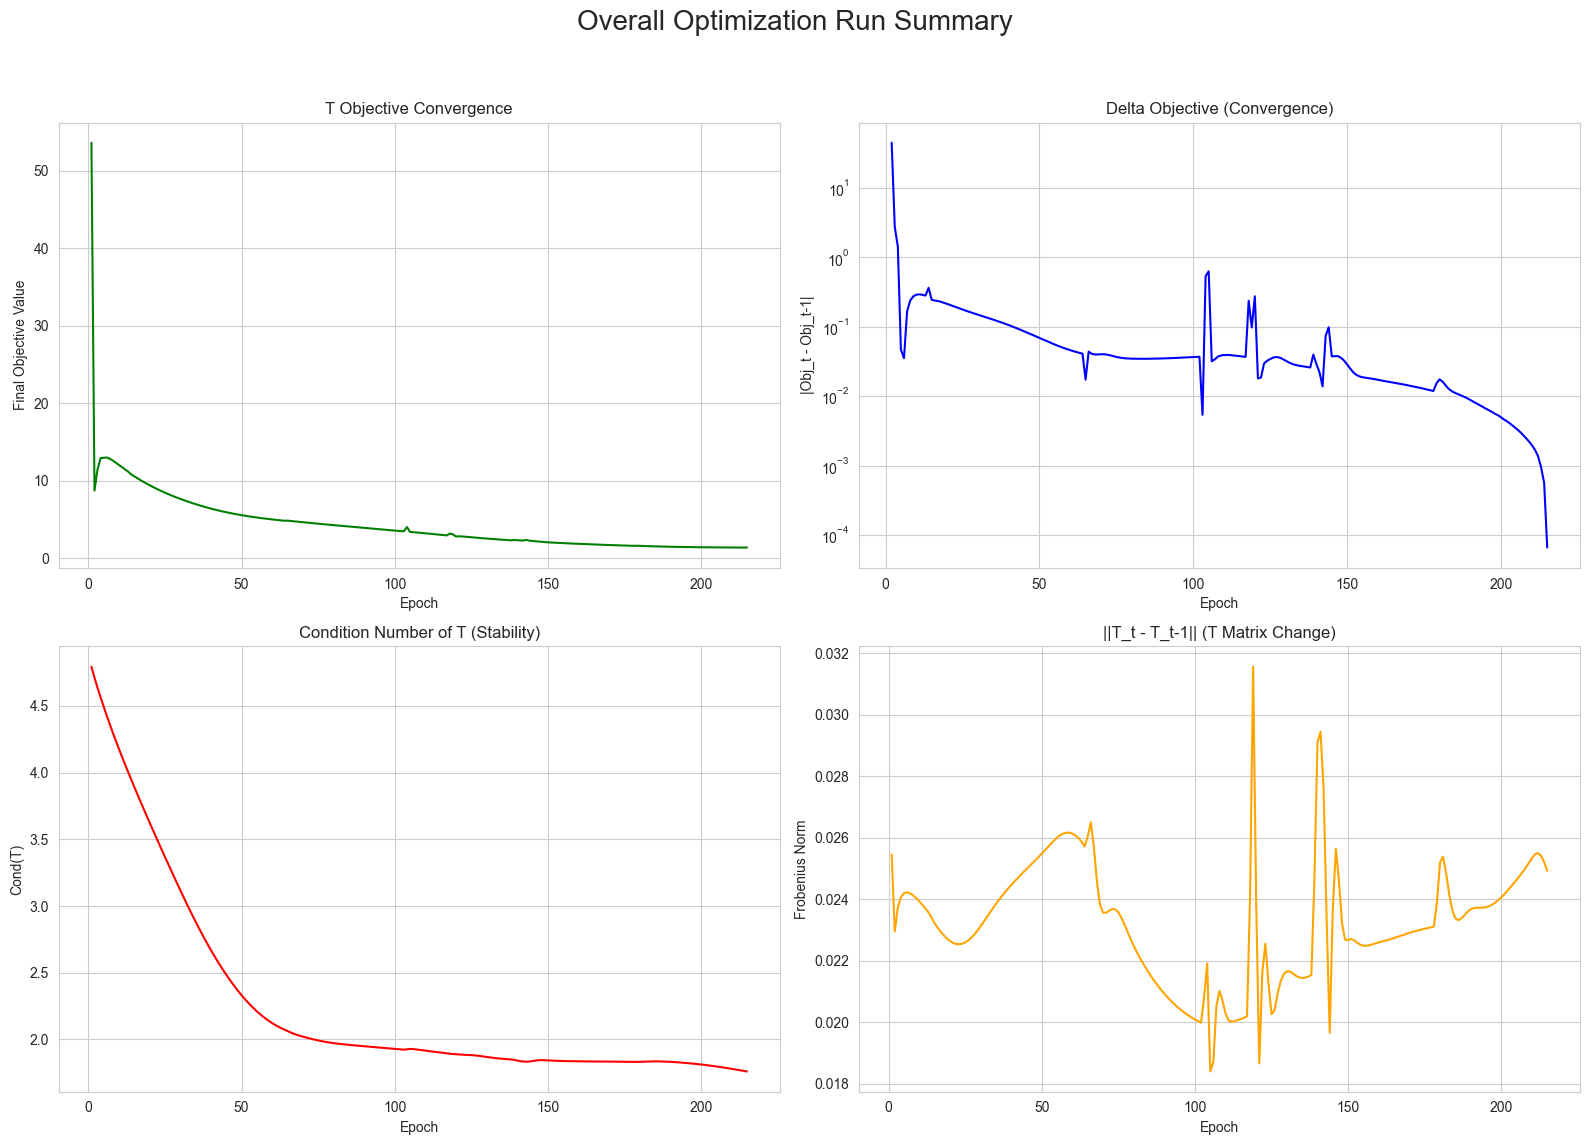

In [19]:
diroca_results['fold_1']['eps_delta_4']['monitor'].plot_run_summary()

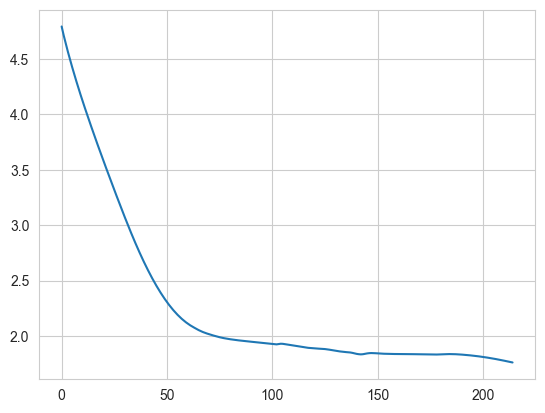

Final Condition Number for eps_delta_8 in fold_0: 1.7602


In [21]:
import joblib
import matplotlib.pyplot as plt

diroca_results = joblib.load(f"data/{experiment}/results/diroca_cv_results.pkl")

# 1. Choose a specific result to inspect
fold_key = 'fold_0'
run_key = 'eps_delta_8' # Example run
result = diroca_results[fold_key][run_key]

# 2. Access the monitor object
monitor = result['monitor']

# 3. Get the list of condition numbers recorded during training
condition_number_history = monitor.condition_numbers

plt.plot(condition_number_history)
plt.show()
# 4. The final condition number is the last element in the list
final_condition_number = condition_number_history[-1]

print(f"Final Condition Number for {run_key} in {fold_key}: {final_condition_number:.4f}")

In [ ]:
diroca_cv_results['fold_1']['eps_delta_4']['monitor'].track_epoch_metrics

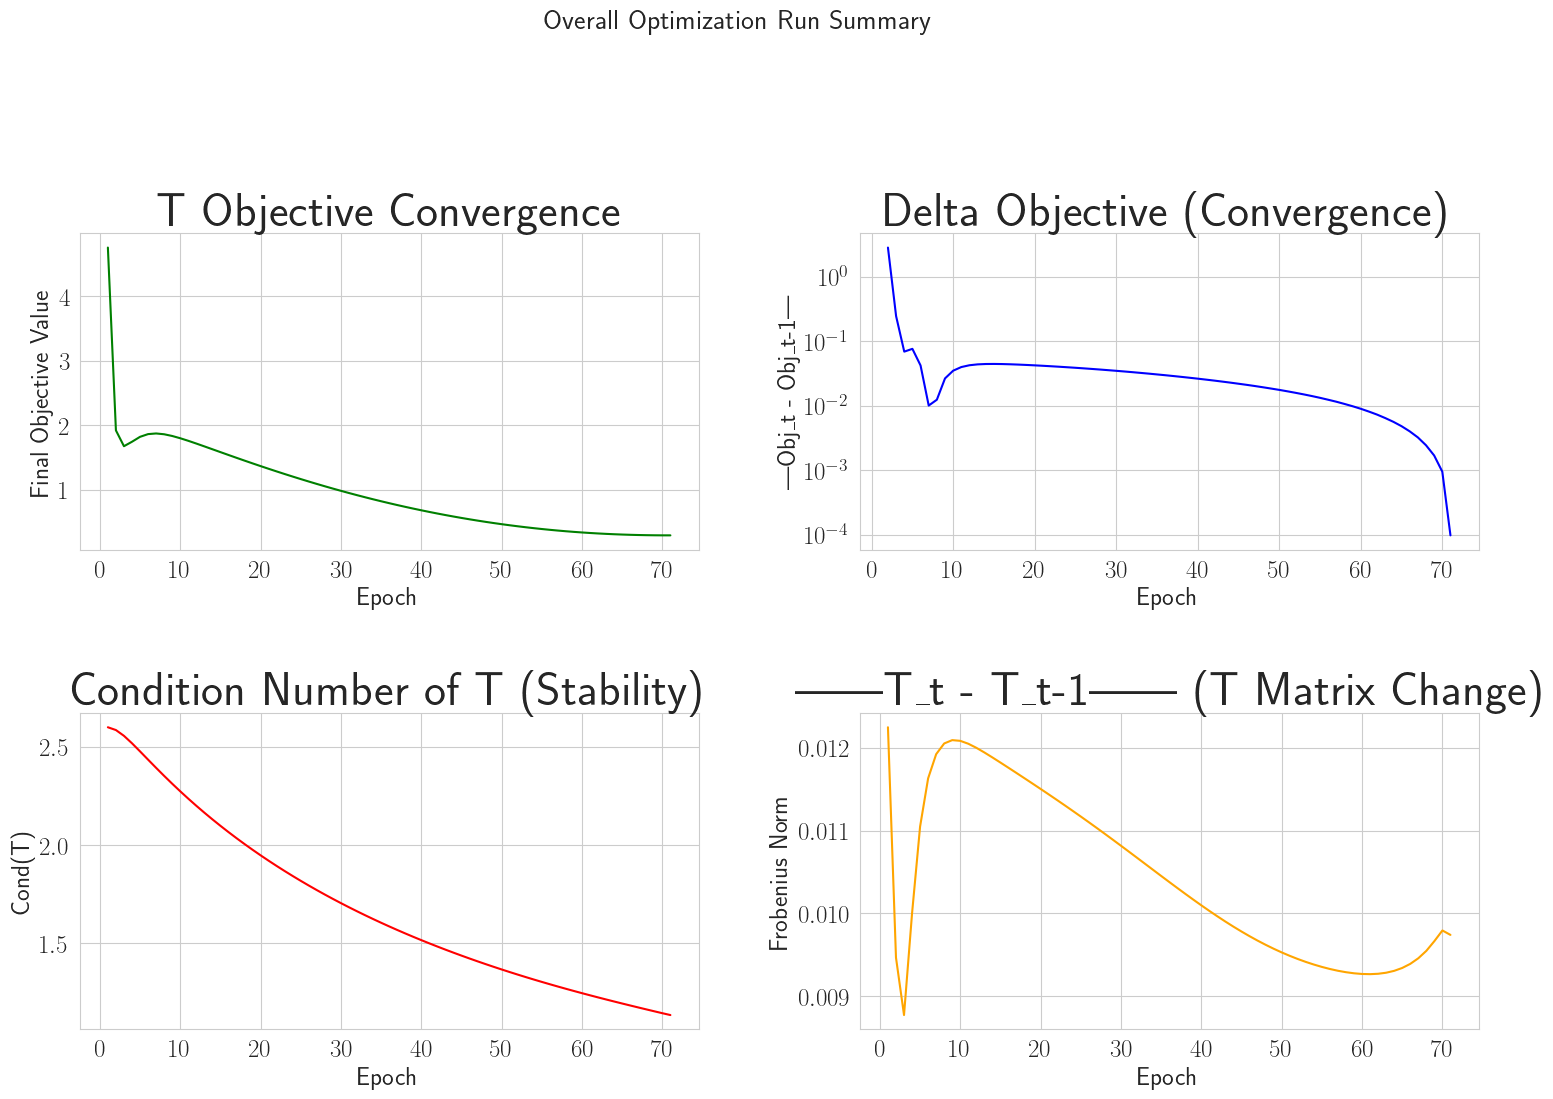

In [73]:
diroca_cv_results['fold_1']['eps_delta_4']['monitor'].plot_run_summary()

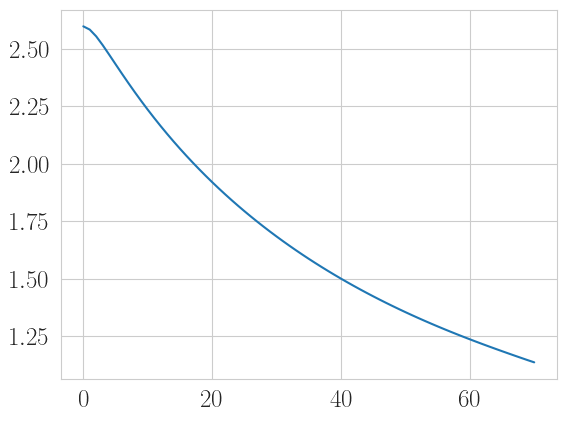

Final Condition Number for eps_delta_8 in fold_0: 1.1358


In [81]:
# 1. Choose a specific result to inspect
fold_key = 'fold_0'
run_key = 'eps_delta_8' # Example run
result = diroca_cv_results[fold_key][run_key]

# 2. Access the monitor object
monitor = result['monitor']

# 3. Get the list of condition numbers recorded during training
condition_number_history = monitor.condition_numbers

plt.plot(condition_number_history)
plt.show()
# 4. The final condition number is the last element in the list
final_condition_number = condition_number_history[-1]

print(f"Final Condition Number for {run_key} in {fold_key}: {final_condition_number:.4f}")

In [26]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def plot_marginal_distributions(final_params, initial_params, var_names, model_name=""):
    """Plots a comparison of the 1D marginals for each variable."""

    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
        "mathtext.fontset": "cm",             # CM-style math
        "mathtext.rm": "serif",
        "font.size": 40,
        "axes.titlesize": 34,
        "axes.labelsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 24,
        "figure.titlesize": 22
    })

#     plt.rcParams.update({
#     "text.usetex": False,                 
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman", "CMU Serif", "DejaVu Serif"],
#     "mathtext.fontset": "cm",             # CM-style math
#     "mathtext.rm": "serif"
# })

    
    mu_final, sigma_final = final_params['mu_U'], final_params['Sigma_U']
    mu_initial, sigma_initial = initial_params['mu_U'], initial_params['Sigma_U']
    
    n_vars = len(var_names)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    #fig.suptitle(f'Marginal Noise Distributions: {model_name}', fontsize=20)
    initial_color = 'skyblue'  # a softer blue
    worst_color = 'mediumorchid'    # a softer red
    legend_color = '#000000'    # a softer red

    # Use these to collect one example of each line for legend
    legend_handles = None

    for i in range(n_vars):
        mean_i, std_i = mu_initial[i], np.sqrt(sigma_initial[i, i])
        x = np.linspace(mean_i - 3*std_i, mean_i + 3*std_i, 200)
        line1, = axes[i].plot(x, norm.pdf(x, mean_i, std_i), initial_color, lw=3, label='Initial (Empirical)')

        mean_f, std_f = mu_final[i], np.sqrt(sigma_final[i, i])
        x = np.linspace(mean_f - 3*std_f, mean_f + 3*std_f, 200)
        line2, = axes[i].plot(x, norm.pdf(x, mean_f, std_f), worst_color, linestyle='--', lw=3, label='Final (Worst-Case)')

        axes[i].set_title(var_names[i], fontsize=18)
        axes[i].tick_params(axis='both', which='major', labelsize=14)

        # Store legend handles from the first plot
        if legend_handles is None:
            legend_handles = [line1, line2]

    # Hide any unused subplots
    for j in range(n_vars, len(axes)):
        fig.delaxes(axes[j])

    # Add a single legend at the bottom
    fig.legend(legend_handles, ['Initial (Empirical)', 'Final (Worst-Case)'],
               loc='lower center', ncol=2, fontsize=14, frameon=False, bbox_to_anchor=(0.5, 0.0))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to fit legend
    plt.show()


In [27]:
fold_to_inspect = 'fold_0'
hyperparam_to_inspect = 'eps_delta_8' # Use a key that exists in your results

result = diroca_results[fold_to_inspect][hyperparam_to_inspect]
monitor = result['monitor']

fold_info = saved_folds[int(fold_to_inspect.split('_')[1])]

initial_params = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_diroca)

initial_params_L = initial_params['theta_hatL']
initial_params_H = initial_params['theta_hatH']

final_params = result['optimization_params']



--- Distribution Summary: Low-Level Model ---

Mean (μ):
  - Initial: [0.  0.  0.1 0.1 0.3 0.2]
  - Final  : [ 0.43  -0.154  0.53   0.094  0.322  0.242]

Variances (diag(Σ)):
  - Initial: [0.5 2.  1.  1.5 0.8 1.2]
  - Final  : [7.39  5.206 3.798 2.397 0.325 0.671]

Final Correlation Matrix:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
----------------------------------------


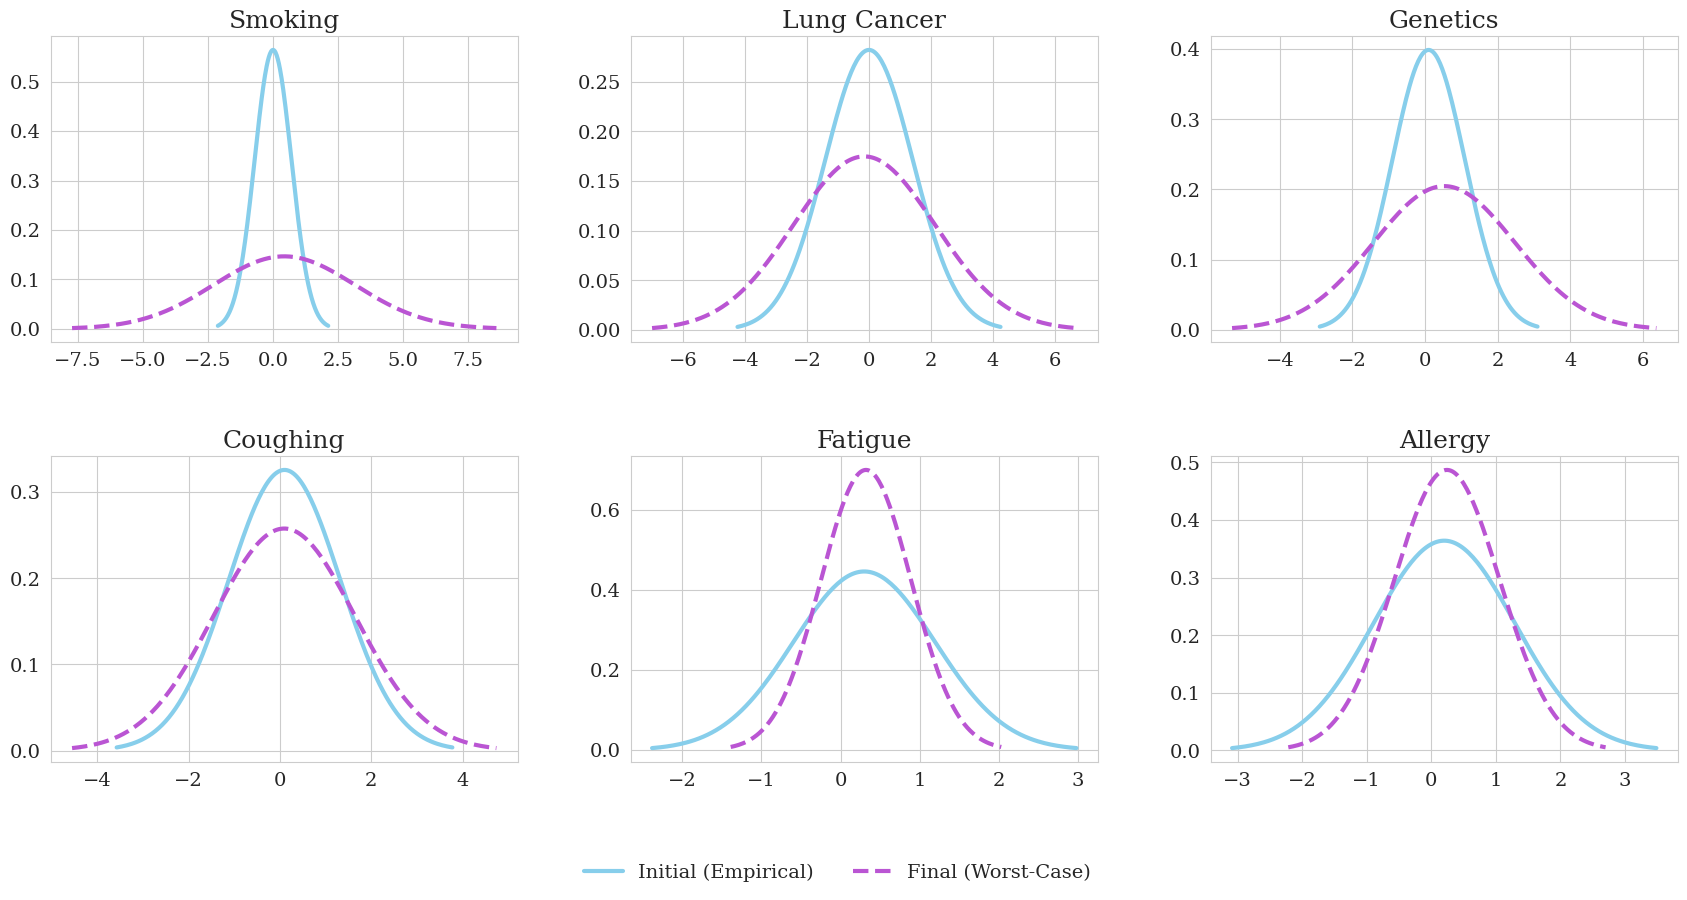


--- Distribution Summary: High-Level Model ---

Mean (μ):
  - Initial: [0.134 0.    0.829]
  - Final  : [-0.296  0.43   1.259]

Variances (diag(Σ)):
  - Initial: [ 5.086  5.484 39.17 ]
  - Final  : [13.173 13.173 13.173]

Final Correlation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
-----------------------------------------


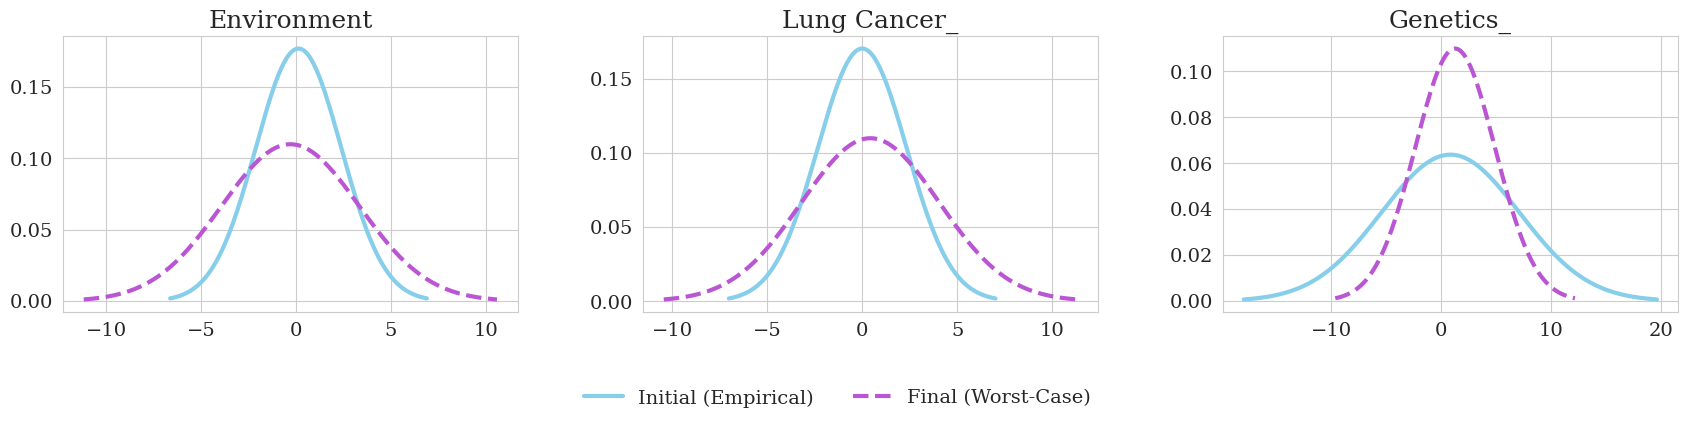

In [29]:
# Print the Numerical Summary for both LL and HL models and plot the marginal distributions
ll_var_names = list(all_data['LLmodel']['graph'].nodes())
hl_var_names = list(all_data['HLmodel']['graph'].nodes())

ut.print_distribution_summary(final_params['L'], initial_params_L, name="Low-Level Model")
plot_marginal_distributions(final_params['L'], initial_params_L, ll_var_names, model_name="Low-Level Model")


ut.print_distribution_summary(final_params['H'], initial_params_H, name="High-Level Model")
plot_marginal_distributions(final_params['H'], initial_params_H, hl_var_names, model_name="High-Level Model")

Total Trajectory Length (Low-Level): 37.3093
Distribution Spread (Low-Level): μ-Spread=0.1714, Σ-Spread=6.0316


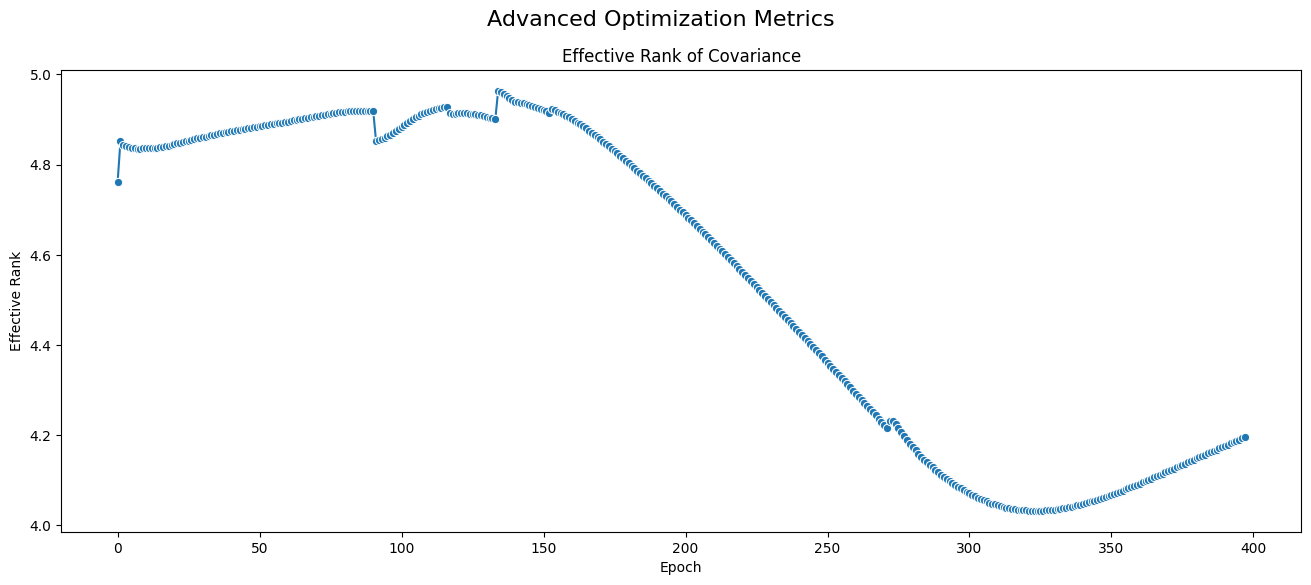

In [9]:
# Metric 1: Trajectory Length
traj_len = monitor.compute_trajectory_length(level='L')
print(f"Total Trajectory Length (Low-Level): {traj_len:.4f}")

# Metric 2: Diversity/Spread
spreads = monitor.compute_spread_metrics(level='L')
print(f"Distribution Spread (Low-Level): μ-Spread={spreads['spread_mu']:.4f}, Σ-Spread={spreads['spread_sigma']:.4f}")

# Metric 3: Effective Rank of Covariance
eff_ranks = monitor.compute_effective_rank_history(level='L')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Advanced Optimization Metrics', fontsize=16)

sns.lineplot(x=range(len(eff_ranks)), y=eff_ranks, marker='o', ax=ax)
ax.set_title('Effective Rank of Covariance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Effective Rank')

plt.show()

In [ ]:
final_results_df['method'].unique()

array(['DIROCA (eps_delta_4)', 'DIROCA (eps_delta_8)',
       'DIROCA (eps_delta_1)', 'DIROCA (eps_delta_2)',
       'DIROCA (eps_delta_0.111)', 'GradCA', 'BARYCA'], dtype=object)

In [10]:
# ll_var_names = list(all_data['LLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, ll_var_names, model_level='L', filename='ll_optimization.gif')

# hl_var_names = list(all_data['HLmodel']['graph'].nodes())
# ut.create_optimization_animation(monitor, initial_params, hl_var_names, model_level='H', filename='hl_optimization.gif')

### 2. GRADCA optimization

In [5]:
gradca_cv_results = {}

# 2. Outer Loop: Iterate through each cross-validation fold
for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Cross-Validation for Fold {i+1}/{len(saved_folds)} ---")
    
    # Create a new sub-dictionary for the current fold
    fold_key = f'fold_{i}'
    gradca_cv_results[fold_key] = {}
    
    # Determine the fold-specific radius bound
    train_n = len(fold_info['train'])

    # Assemble parameters for this specific run
    params_for_this_run = ut.assemble_fold_parameters(fold_info, all_data, hyperparams_gradca)
   
    # Prepare arguments for the optimization function
    opt_args = params_for_this_run.copy()
    opt_args.pop('k_folds', None)
    
    # Run the optimization
    trained_params, trained_T, monitor = optools.run_erica_optimization(**opt_args)

    # Store the results
    gradca_cv_results[fold_key] = {
        'gradca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
    
print("\n\n--- Optimization Complete ---")


--- Starting Cross-Validation for Fold 1/5 ---
Running optimization on device: cpu


Optimizing:  14%|█▍        | 424/3000 [00:15<01:35, 26.87it/s]


KeyboardInterrupt: 

### 3. BARYCA optimization

In [ ]:
baryca_cv_results = {}

for i, fold_info in enumerate(saved_folds):
    print(f"\n--- Starting Barycentric Optimization for Fold {i+1}/{len(saved_folds)} ---")
    
    opt_args = ut.assemble_barycentric_parameters(fold_info, all_data, hyperparams_baryca)
    opt_args.pop('k_folds', None)

    # Run the optimization
    trained_params, trained_T = optools.barycentric_optimization(**opt_args)
    
    # Store the results 
    fold_key = f'fold_{i}'

    # Store the results
    baryca_cv_results[fold_key] = {
        'baryca_run': {
            'T_matrix': trained_T,
            'test_indices': fold_info['test'] 
        }
    }
print("\n\n--- Optimization Complete ---")


--- Starting Barycentric Optimization for Fold 1/2 ---

--- Starting Barycentric Optimization for Fold 2/2 ---


--- Optimization Complete ---


## Save the results

In [15]:
joblib.dump(diroca_cv_results, f"data/{experiment}/diroca_cv_results.pkl")
joblib.dump(gradca_cv_results, f"data/{experiment}/gradca_cv_results.pkl")
joblib.dump(baryca_cv_results, f"data/{experiment}/baryca_cv_results.pkl")

print("All results have been saved successfully!")

All results have been saved successfully!


In [ ]:
def plot_hyperparameter_sensitivity(results_data, experiment='lilucas', save_plots=True):
    """
    Analyze the effect of hyperparameters on performance.
    """
    # Extract hyperparameter data from grid search results
    hyperparam_data = []
    
    # Process DIROCA grid search results
    if 'diroca_grid' in results_data:
        grid_results = results_data['diroca_grid']
        for result in grid_results:
            params = result.get('params', {})
            hyperparam_data.append({
                'method': 'DIROCA',
                'eps_delta': params.get('eps_delta', 'unknown'),
                'eta_min': params.get('eta_min', 'unknown'),
                'tol': params.get('tol', 'unknown'),
                'max_iter': params.get('max_iter', 'unknown'),
                'mean_error_0shift': result.get('mean_error_0shift', np.nan),
                'mean_error_rhoshift': result.get('mean_error_rhoshift', np.nan),
                'std_error_0shift': result.get('std_error_0shift', np.nan),
                'std_error_rhoshift': result.get('std_error_rhoshift', np.nan)
            })
    
    # Process GRADCA empirical grid search results
    if 'gradca_emp_grid' in results_data:
        grid_results = results_data['gradca_emp_grid']
        for result in grid_results:
            params = result.get('params', {})
            hyperparam_data.append({
                'method': 'GRADCA_EMP',
                'eta_min': params.get('eta_min', 'unknown'),
                'tol': params.get('tol', 'unknown'),
                'max_iter': params.get('max_iter', 'unknown'),
                'xavier': params.get('xavier', 'unknown'),
                'mean_error_0shift': result.get('mean_error_0shift', np.nan),
                'mean_error_rhoshift': result.get('mean_error_rhoshift', np.nan),
                'std_error_0shift': result.get('std_error_0shift', np.nan),
                'std_error_rhoshift': result.get('std_error_rhoshift', np.nan)
            })
    
    if len(hyperparam_data) == 0:
        print("⚠️  No hyperparameter data available for analysis")
        return
    
    df = pd.DataFrame(hyperparam_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Hyperparameter Sensitivity Analysis - {experiment.upper()}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Learning rate vs performance (for methods that have eta_min)
    ax1 = axes[0, 0]
    methods_with_eta = df[df['eta_min'] != 'unknown']
    if len(methods_with_eta) > 0:
        for method in methods_with_eta['method'].unique():
            method_data = methods_with_eta[methods_with_eta['method'] == method]
            # Convert eta_min to numeric for plotting
            eta_values = []
            errors = []
            for _, row in method_data.iterrows():
                try:
                    eta_val = float(row['eta_min'])
                    eta_values.append(eta_val)
                    errors.append(row['mean_error_0shift'])
                except (ValueError, TypeError):
                    continue
            
            if eta_values:
                ax1.scatter(eta_values, errors, label=method, s=100, alpha=0.7)
        
        ax1.set_xlabel('Learning Rate (eta_min)')
        ax1.set_ylabel('Mean 0-Shift Error')
        ax1.set_xscale('log')
        ax1.legend()
        ax1.set_title('Learning Rate vs Performance')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No learning rate data available', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Learning Rate vs Performance')
    
    # Plot 2: Tolerance vs performance
    ax2 = axes[0, 1]
    methods_with_tol = df[df['tol'] != 'unknown']
    if len(methods_with_tol) > 0:
        for method in methods_with_tol['method'].unique():
            method_data = methods_with_tol[methods_with_tol['method'] == method]
            tol_values = []
            errors = []
            for _, row in method_data.iterrows():
                try:
                    tol_val = float(row['tol'])
                    tol_values.append(tol_val)
                    errors.append(row['mean_error_0shift'])
                except (ValueError, TypeError):
                    continue
            
            if tol_values:
                ax2.scatter(tol_values, errors, label=method, s=100, alpha=0.7)
        
        ax2.set_xlabel('Tolerance')
        ax2.set_ylabel('Mean 0-Shift Error')
        ax2.set_xscale('log')
        ax2.legend()
        ax2.set_title('Tolerance vs Performance')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No tolerance data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Tolerance vs Performance')
    
    # Plot 3: Max iterations vs performance
    ax3 = axes[1, 0]
    methods_with_max_iter = df[df['max_iter'] != 'unknown']
    if len(methods_with_max_iter) > 0:
        for method in methods_with_max_iter['method'].unique():
            method_data = methods_with_max_iter[methods_with_max_iter['method'] == method]
            max_iter_values = []
            errors = []
            for _, row in method_data.iterrows():
                try:
                    max_iter_val = int(row['max_iter'])
                    max_iter_values.append(max_iter_val)
                    errors.append(row['mean_error_0shift'])
                except (ValueError, TypeError):
                    continue
            
            if max_iter_values:
                ax3.scatter(max_iter_values, errors, label=method, s=100, alpha=0.7)
        
        ax3.set_xlabel('Max Iterations')
        ax3.set_ylabel('Mean 0-Shift Error')
        ax3.legend()
        ax3.set_title('Max Iterations vs Performance')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No max iterations data available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Max Iterations vs Performance')
    
    # Plot 4: DIROCA epsilon/delta sensitivity
    ax4 = axes[1, 1]
    diroca_data = df[df['method'] == 'DIROCA']
    if len(diroca_data) > 0 and 'eps_delta' in diroca_data.columns:
        eps_values = []
        errors_0shift = []
        errors_rhoshift = []
        
        for _, row in diroca_data.iterrows():
            try:
                eps_val = float(row['eps_delta'])
                eps_values.append(eps_val)
                errors_0shift.append(row['mean_error_0shift'])
                errors_rhoshift.append(row['mean_error_rhoshift'])
            except (ValueError, TypeError):
                continue
        
        if eps_values:
            ax4.scatter(eps_values, errors_0shift, label='0-Shift Error', 
                       s=100, alpha=0.7, marker='o')
            ax4.scatter(eps_values, errors_rhoshift, label='Rho-Shift Error', 
                       s=100, alpha=0.7, marker='s')
            ax4.set_xlabel('Epsilon/Delta')
            ax4.set_ylabel('Mean Error')
            ax4.legend()
            ax4.set_title('DIROCA Robustness Radius Sensitivity')
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'No epsilon/delta data available', 
                    ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('DIROCA Robustness Radius Sensitivity')
    else:
        ax4.text(0.5, 0.5, 'No DIROCA data available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('DIROCA Robustness Radius Sensitivity')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/hyperparameter_sensitivity_{experiment}.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot: plots/hyperparameter_sensitivity_{experiment}.png")
    
    plt.show()
    
    # Print summary
    print(f"\n📊 Hyperparameter Sensitivity Summary for {experiment.upper()}:")
    print(f"Total hyperparameter combinations: {len(df)}")
    print(f"Methods analyzed: {', '.join(df['method'].unique())}")
    
    # Find best hyperparameters
    if 'mean_error_0shift' in df.columns:
        best_idx = df['mean_error_0shift'].idxmin()
        best_result = df.loc[best_idx]
        print(f"Best 0-shift performance: {best_result['mean_error_0shift']:.6f}")
        print(f"Best hyperparameters: {best_result.to_dict()}")

# Run the hyperparameter analysis
plot_hyperparameter_sensitivity(results_data, experiment)


In [ ]:
def plot_training_curves(results_data, experiment='lilucas', save_plots=True):
    """
    Visualize training curves and optimization progress.
    """
    # Extract training curve data
    training_data = []
    
    # Process DIROCA results (they have monitor objects with training curves)
    if 'diroca' in results_data:
        diroca_data = results_data['diroca']
        for fold_key, fold_data in diroca_data.items():
            for hyperparam_key, run_data in fold_data.items():
                if 'monitor' in run_data:
                    monitor = run_data['monitor']
                    # Extract training metrics if available
                    if hasattr(monitor, 'train_losses'):
                        for i, loss in enumerate(monitor.train_losses):
                            training_data.append({
                                'method': 'DIROCA',
                                'fold': fold_key,
                                'hyperparam': hyperparam_key,
                                'iteration': i,
                                'loss': loss,
                                'type': 'Training Loss'
                            })
                    
                    # Extract condition numbers if available
                    if hasattr(monitor, 'condition_numbers'):
                        for i, cond_num in enumerate(monitor.condition_numbers):
                            training_data.append({
                                'method': 'DIROCA',
                                'fold': fold_key,
                                'hyperparam': hyperparam_key,
                                'iteration': i,
                                'loss': cond_num,
                                'type': 'Condition Number'
                            })
    
    if len(training_data) == 0:
        print("⚠️  No training curve data available")
        return
    
    df = pd.DataFrame(training_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Training Curves Analysis - {experiment.upper()}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Training loss curves
    ax1 = axes[0, 0]
    loss_data = df[df['type'] == 'Training Loss']
    if len(loss_data) > 0:
        for (method, fold, hyperparam), group in loss_data.groupby(['method', 'fold', 'hyperparam']):
            label = f"{method} {fold} {hyperparam}"
            ax1.plot(group['iteration'], group['loss'], label=label, alpha=0.7)
        
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel('Training Loss')
        ax1.set_title('Training Loss Curves')
        ax1.set_yscale('log')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'No training loss data available', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Training Loss Curves')
    
    # Plot 2: Condition number evolution
    ax2 = axes[0, 1]
    cond_data = df[df['type'] == 'Condition Number']
    if len(cond_data) > 0:
        for (method, fold, hyperparam), group in cond_data.groupby(['method', 'fold', 'hyperparam']):
            label = f"{method} {fold} {hyperparam}"
            ax2.plot(group['iteration'], group['loss'], label=label, alpha=0.7)
        
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('Condition Number')
        ax2.set_title('Condition Number Evolution')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No condition number data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Condition Number Evolution')
    
    # Plot 3: Loss distribution by method
    ax3 = axes[1, 0]
    if len(loss_data) > 0:
        method_losses = []
        method_names = []
        for method in loss_data['method'].unique():
            method_data = loss_data[loss_data['method'] == method]
            final_losses = method_data.groupby(['fold', 'hyperparam'])['loss'].last()
            method_losses.append(final_losses.values)
            method_names.append(method)
        
        ax3.boxplot(method_losses, labels=method_names)
        ax3.set_ylabel('Final Training Loss')
        ax3.set_title('Final Loss Distribution by Method')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'No loss data available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Final Loss Distribution by Method')
    
    # Plot 4: Convergence analysis
    ax4 = axes[1, 1]
    if len(loss_data) > 0:
        convergence_data = []
        for (method, fold, hyperparam), group in loss_data.groupby(['method', 'fold', 'hyperparam']):
            # Calculate convergence metrics
            total_iterations = len(group)
            final_loss = group['loss'].iloc[-1]
            initial_loss = group['loss'].iloc[0]
            convergence_ratio = final_loss / initial_loss if initial_loss > 0 else np.nan
            
            convergence_data.append({
                'method': method,
                'fold': fold,
                'hyperparam': hyperparam,
                'total_iterations': total_iterations,
                'convergence_ratio': convergence_ratio,
                'final_loss': final_loss
            })
        
        conv_df = pd.DataFrame(convergence_data)
        
        # Scatter plot: iterations vs convergence ratio
        for method in conv_df['method'].unique():
            method_data = conv_df[conv_df['method'] == method]
            ax4.scatter(method_data['total_iterations'], method_data['convergence_ratio'], 
                       label=method, s=100, alpha=0.7)
        
        ax4.set_xlabel('Total Iterations')
        ax4.set_ylabel('Convergence Ratio (Final/Initial Loss)')
        ax4.set_title('Convergence Analysis')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No convergence data available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Convergence Analysis')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/training_curves_{experiment}.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot: plots/training_curves_{experiment}.png")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Training Curves Summary for {experiment.upper()}:")
    print(f"Total training points: {len(df)}")
    print(f"Methods: {', '.join(df['method'].unique())}")
    print(f"Metrics: {', '.join(df['type'].unique())}")
    
    if len(loss_data) > 0:
        print(f"Average final training loss: {loss_data.groupby(['method', 'fold', 'hyperparam'])['loss'].last().mean():.6f}")
        print(f"Min final training loss: {loss_data.groupby(['method', 'fold', 'hyperparam'])['loss'].last().min():.6f}")
        print(f"Max final training loss: {loss_data.groupby(['method', 'fold', 'hyperparam'])['loss'].last().max():.6f}")

# Run the training curves analysis
plot_training_curves(results_data, experiment)


In [ ]:
def plot_robustness_analysis(results_data, experiment='lilucas', save_plots=True):
    """
    Analyze robustness to contamination (0-shift vs rho-shift performance).
    """
    # Extract robustness data
    robustness_data = []
    
    # Process grid search results that have both 0-shift and rho-shift errors
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):  # Grid search results
            for result in result_data:
                if 'mean_error_0shift' in result and 'mean_error_rhoshift' in result:
                    params = result.get('params', {})
                    robustness_data.append({
                        'method': result_key.replace('_grid', '').replace('_emp', '_EMP').upper(),
                        'eps_delta': params.get('eps_delta', 'unknown'),
                        'eta_min': params.get('eta_min', 'unknown'),
                        'tol': params.get('tol', 'unknown'),
                        'max_iter': params.get('max_iter', 'unknown'),
                        'error_0shift': result['mean_error_0shift'],
                        'error_rhoshift': result['mean_error_rhoshift'],
                        'std_0shift': result.get('std_error_0shift', 0),
                        'std_rhoshift': result.get('std_error_rhoshift', 0),
                        'robustness_ratio': result['mean_error_rhoshift'] / result['mean_error_0shift'] if result['mean_error_0shift'] > 0 else np.inf
                    })
    
    if len(robustness_data) == 0:
        print("⚠️  No robustness data available")
        return
    
    df = pd.DataFrame(robustness_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Robustness Analysis - {experiment.upper()}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: 0-shift vs rho-shift error scatter
    ax1 = axes[0, 0]
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        ax1.scatter(method_data['error_0shift'], method_data['error_rhoshift'], 
                   label=method, s=100, alpha=0.7)
    
    # Add diagonal line (perfect robustness)
    max_error = max(df['error_0shift'].max(), df['error_rhoshift'].max())
    ax1.plot([0, max_error], [0, max_error], 'k--', alpha=0.5, label='Perfect Robustness')
    
    ax1.set_xlabel('0-Shift Error')
    ax1.set_ylabel('Rho-Shift Error')
    ax1.set_title('0-Shift vs Rho-Shift Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Robustness ratio by method
    ax2 = axes[0, 1]
    method_robustness = df.groupby('method')['robustness_ratio'].agg(['mean', 'std', 'count'])
    
    bars = ax2.bar(method_robustness.index, method_robustness['mean'], 
                   yerr=method_robustness['std'], capsize=5, alpha=0.7)
    ax2.set_ylabel('Robustness Ratio (Rho-Shift / 0-Shift)')
    ax2.set_title('Robustness Ratio by Method')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean_val in zip(bars, method_robustness['mean']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{mean_val:.2f}', ha='center', va='bottom')
    
    # Plot 3: DIROCA epsilon/delta vs robustness
    ax3 = axes[1, 0]
    diroca_data = df[df['method'].str.contains('DIROCA')]
    if len(diroca_data) > 0 and 'eps_delta' in diroca_data.columns:
        eps_values = []
        robustness_ratios = []
        
        for _, row in diroca_data.iterrows():
            try:
                eps_val = float(row['eps_delta'])
                eps_values.append(eps_val)
                robustness_ratios.append(row['robustness_ratio'])
            except (ValueError, TypeError):
                continue
        
        if eps_values:
            ax3.scatter(eps_values, robustness_ratios, s=100, alpha=0.7, c='red')
            ax3.set_xlabel('Epsilon/Delta')
            ax3.set_ylabel('Robustness Ratio')
            ax3.set_title('DIROCA: Robustness vs Radius')
            ax3.grid(True, alpha=0.3)
            
            # Add trend line
            if len(eps_values) > 1:
                z = np.polyfit(eps_values, robustness_ratios, 1)
                p = np.poly1d(z)
                ax3.plot(eps_values, p(eps_values), "r--", alpha=0.8)
        else:
            ax3.text(0.5, 0.5, 'No epsilon/delta data available', 
                    ha='center', va='center', transform=ax3.transAxes)
            ax3.set_title('DIROCA: Robustness vs Radius')
    else:
        ax3.text(0.5, 0.5, 'No DIROCA data available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('DIROCA: Robustness vs Radius')
    
    # Plot 4: Error degradation analysis
    ax4 = axes[1, 1]
    degradation_data = []
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        avg_0shift = method_data['error_0shift'].mean()
        avg_rhoshift = method_data['error_rhoshift'].mean()
        degradation = (avg_rhoshift - avg_0shift) / avg_0shift * 100 if avg_0shift > 0 else 0
        
        degradation_data.append({
            'method': method,
            'degradation_percent': degradation,
            'avg_0shift': avg_0shift,
            'avg_rhoshift': avg_rhoshift
        })
    
    deg_df = pd.DataFrame(degradation_data)
    colors = ['red' if x > 0 else 'green' for x in deg_df['degradation_percent']]
    
    bars = ax4.bar(deg_df['method'], deg_df['degradation_percent'], color=colors, alpha=0.7)
    ax4.set_ylabel('Performance Degradation (%)')
    ax4.set_title('Performance Degradation Under Contamination')
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars, deg_df['degradation_percent']):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                f'{val:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/robustness_analysis_{experiment}.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot: plots/robustness_analysis_{experiment}.png")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n📊 Robustness Analysis Summary for {experiment.upper()}:")
    print(f"Total experiments: {len(df)}")
    print(f"Methods analyzed: {', '.join(df['method'].unique())}")
    
    # Find most robust method
    if len(deg_df) > 0:
        most_robust = deg_df.loc[deg_df['degradation_percent'].idxmin()]
        least_robust = deg_df.loc[deg_df['degradation_percent'].idxmax()]
        
        print(f"Most robust method: {most_robust['method']} ({most_robust['degradation_percent']:.1f}% degradation)")
        print(f"Least robust method: {least_robust['method']} ({least_robust['degradation_percent']:.1f}% degradation)")
        
        # DIROCA specific analysis
        diroca_methods = deg_df[deg_df['method'].str.contains('DIROCA')]
        if len(diroca_methods) > 0:
            print(f"DIROCA average degradation: {diroca_methods['degradation_percent'].mean():.1f}%")

# Run the robustness analysis
plot_robustness_analysis(results_data, experiment)


In [ ]:
def plot_empirical_vs_gaussian(results_data, experiment='lilucas', save_plots=True):
    """
    Compare empirical vs gaussian methods performance.
    """
    # Extract comparison data
    comparison_data = []
    
    # Process both empirical and gaussian results
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):  # Grid search results
            for result in result_data:
                if 'mean_error_0shift' in result and 'mean_error_rhoshift' in result:
                    method_type = 'Empirical' if 'emp' in result_key else 'Gaussian'
                    method_name = result_key.replace('_grid', '').replace('_emp', '').upper()
                    
                    comparison_data.append({
                        'method': method_name,
                        'type': method_type,
                        'error_0shift': result['mean_error_0shift'],
                        'error_rhoshift': result['mean_error_rhoshift'],
                        'std_0shift': result.get('std_error_0shift', 0),
                        'std_rhoshift': result.get('std_error_rhoshift', 0),
                        'robustness_ratio': result['mean_error_rhoshift'] / result['mean_error_0shift'] if result['mean_error_0shift'] > 0 else np.inf
                    })
    
    if len(comparison_data) == 0:
        print("⚠️  No comparison data available")
        return
    
    df = pd.DataFrame(comparison_data)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Empirical vs Gaussian Methods - {experiment.upper()}', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: 0-shift error comparison
    ax1 = axes[0, 0]
    type_0shift = df.groupby('type')['error_0shift'].agg(['mean', 'std', 'count'])
    
    bars = ax1.bar(type_0shift.index, type_0shift['mean'], 
                   yerr=type_0shift['std'], capsize=5, alpha=0.7,
                   color=['skyblue', 'lightcoral'])
    ax1.set_ylabel('Mean 0-Shift Error')
    ax1.set_title('0-Shift Performance: Empirical vs Gaussian')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, type_0shift['mean']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{mean_val:.2f}', ha='center', va='bottom')
    
    # Plot 2: Rho-shift error comparison
    ax2 = axes[0, 1]
    type_rhoshift = df.groupby('type')['error_rhoshift'].agg(['mean', 'std', 'count'])
    
    bars = ax2.bar(type_rhoshift.index, type_rhoshift['mean'], 
                   yerr=type_rhoshift['std'], capsize=5, alpha=0.7,
                   color=['skyblue', 'lightcoral'])
    ax2.set_ylabel('Mean Rho-Shift Error')
    ax2.set_title('Rho-Shift Performance: Empirical vs Gaussian')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, type_rhoshift['mean']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{mean_val:.2f}', ha='center', va='bottom')
    
    # Plot 3: Robustness ratio comparison
    ax3 = axes[1, 0]
    type_robustness = df.groupby('type')['robustness_ratio'].agg(['mean', 'std', 'count'])
    
    bars = ax3.bar(type_robustness.index, type_robustness['mean'], 
                   yerr=type_robustness['std'], capsize=5, alpha=0.7,
                   color=['skyblue', 'lightcoral'])
    ax3.set_ylabel('Mean Robustness Ratio')
    ax3.set_title('Robustness: Empirical vs Gaussian')
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean_val in zip(bars, type_robustness['mean']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{mean_val:.2f}', ha='center', va='bottom')
    
    # Plot 4: Method-wise comparison
    ax4 = axes[1, 1]
    method_comparison = df.groupby(['method', 'type']).agg({
        'error_0shift': 'mean',
        'error_rhoshift': 'mean'
    }).reset_index()
    
    # Create grouped bar plot
    methods = method_comparison['method'].unique()
    x = np.arange(len(methods))
    width = 0.35
    
    empirical_0shift = [method_comparison[(method_comparison['method'] == m) & 
                                        (method_comparison['type'] == 'Empirical')]['error_0shift'].iloc[0] 
                       if len(method_comparison[(method_comparison['method'] == m) & 
                                              (method_comparison['type'] == 'Empirical')]) > 0 
                       else 0 for m in methods]
    
    gaussian_0shift = [method_comparison[(method_comparison['method'] == m) & 
                                        (method_comparison['type'] == 'Gaussian')]['error_0shift'].iloc[0] 
                      if len(method_comparison[(method_comparison['method'] == m) & 
                                             (method_comparison['type'] == 'Gaussian')]) > 0 
                      else 0 for m in methods]
    
    bars1 = ax4.bar(x - width/2, empirical_0shift, width, label='Empirical', alpha=0.7, color='skyblue')
    bars2 = ax4.bar(x + width/2, gaussian_0shift, width, label='Gaussian', alpha=0.7, color='lightcoral')
    
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Mean 0-Shift Error')
    ax4.set_title('Method-wise 0-Shift Performance')
    ax4.set_xticks(x)
    ax4.set_xticklabels(methods, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'plots/empirical_vs_gaussian_{experiment}.png', dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot: plots/empirical_vs_gaussian_{experiment}.png")
    
    plt.show()
    
    # Print detailed comparison
    print(f"\n📊 Empirical vs Gaussian Comparison for {experiment.upper()}:")
    
    # Overall comparison
    emp_data = df[df['type'] == 'Empirical']
    gauss_data = df[df['type'] == 'Gaussian']
    
    if len(emp_data) > 0 and len(gauss_data) > 0:
        print(f"Empirical methods:")
        print(f"  - Average 0-shift error: {emp_data['error_0shift'].mean():.6f} ± {emp_data['error_0shift'].std():.6f}")
        print(f"  - Average rho-shift error: {emp_data['error_rhoshift'].mean():.6f} ± {emp_data['error_rhoshift'].std():.6f}")
        print(f"  - Average robustness ratio: {emp_data['robustness_ratio'].mean():.2f} ± {emp_data['robustness_ratio'].std():.2f}")
        
        print(f"Gaussian methods:")
        print(f"  - Average 0-shift error: {gauss_data['error_0shift'].mean():.6f} ± {gauss_data['error_0shift'].std():.6f}")
        print(f"  - Average rho-shift error: {gauss_data['error_rhoshift'].mean():.6f} ± {gauss_data['error_rhoshift'].std():.6f}")
        print(f"  - Average robustness ratio: {gauss_data['robustness_ratio'].mean():.2f} ± {gauss_data['robustness_ratio'].std():.2f}")
        
        # Performance comparison
        emp_better_0shift = emp_data['error_0shift'].mean() < gauss_data['error_0shift'].mean()
        emp_better_robust = emp_data['robustness_ratio'].mean() < gauss_data['robustness_ratio'].mean()
        
        print(f"\nPerformance Summary:")
        print(f"  - Better 0-shift performance: {'Empirical' if emp_better_0shift else 'Gaussian'}")
        print(f"  - Better robustness: {'Empirical' if emp_better_robust else 'Gaussian'}")

# Run the empirical vs gaussian comparison
plot_empirical_vs_gaussian(results_data, experiment)


In [ ]:
def create_summary_report(results_data, experiment='lilucas', save_report=True):
    """
    Create a comprehensive summary report of all results.
    """
    print("="*80)
    print(f"📋 COMPREHENSIVE RESULTS SUMMARY - {experiment.upper()}")
    print("="*80)
    
    # Count total experiments
    total_experiments = 0
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):
            total_experiments += len(result_data)
        elif isinstance(result_data, dict):
            total_experiments += 1
    
    print(f"📊 Total experiments analyzed: {total_experiments}")
    print(f"📁 Result files loaded: {len(results_data)}")
    
    # Method summary
    methods_found = []
    for result_key in results_data.keys():
        method_name = result_key.replace('_grid', '').replace('_emp', '_EMP').upper()
        if method_name not in methods_found:
            methods_found.append(method_name)
    
    print(f"🔬 Methods analyzed: {', '.join(methods_found)}")
    
    # Performance summary
    all_errors = []
    all_robustness_ratios = []
    
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):
            for result in result_data:
                if 'mean_error_0shift' in result:
                    all_errors.append(result['mean_error_0shift'])
                if 'mean_error_0shift' in result and 'mean_error_rhoshift' in result:
                    if result['mean_error_0shift'] > 0:
                        all_robustness_ratios.append(result['mean_error_rhoshift'] / result['mean_error_0shift'])
    
    if all_errors:
        print(f"\n📈 Performance Statistics:")
        print(f"  - Best 0-shift error: {min(all_errors):.6f}")
        print(f"  - Worst 0-shift error: {max(all_errors):.6f}")
        print(f"  - Average 0-shift error: {np.mean(all_errors):.6f} ± {np.std(all_errors):.6f}")
    
    if all_robustness_ratios:
        print(f"  - Best robustness ratio: {min(all_robustness_ratios):.2f}")
        print(f"  - Worst robustness ratio: {max(all_robustness_ratios):.2f}")
        print(f"  - Average robustness ratio: {np.mean(all_robustness_ratios):.2f} ± {np.std(all_robustness_ratios):.2f}")
    
    # Best performing configurations
    print(f"\n🏆 Best Performing Configurations:")
    
    best_0shift = None
    best_robust = None
    best_0shift_error = float('inf')
    best_robust_ratio = float('inf')
    
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):
            for result in result_data:
                if 'mean_error_0shift' in result and result['mean_error_0shift'] < best_0shift_error:
                    best_0shift_error = result['mean_error_0shift']
                    best_0shift = {
                        'method': result_key.replace('_grid', '').replace('_emp', '_EMP').upper(),
                        'params': result.get('params', {}),
                        'error': result['mean_error_0shift']
                    }
                
                if ('mean_error_0shift' in result and 'mean_error_rhoshift' in result and 
                    result['mean_error_0shift'] > 0):
                    robust_ratio = result['mean_error_rhoshift'] / result['mean_error_0shift']
                    if robust_ratio < best_robust_ratio:
                        best_robust_ratio = robust_ratio
                        best_robust = {
                            'method': result_key.replace('_grid', '').replace('_emp', '_EMP').upper(),
                            'params': result.get('params', {}),
                            'robustness_ratio': robust_ratio
                        }
    
    if best_0shift:
        print(f"  - Best 0-shift performance:")
        print(f"    Method: {best_0shift['method']}")
        print(f"    Error: {best_0shift['error']:.6f}")
        print(f"    Parameters: {best_0shift['params']}")
    
    if best_robust:
        print(f"  - Best robustness:")
        print(f"    Method: {best_robust['method']}")
        print(f"    Robustness ratio: {best_robust['robustness_ratio']:.2f}")
        print(f"    Parameters: {best_robust['params']}")
    
    # Recommendations
    print(f"\n💡 Key Insights:")
    
    # Find DIROCA results
    diroca_results = []
    for result_key, result_data in results_data.items():
        if 'diroca' in result_key.lower() and isinstance(result_data, list):
            diroca_results.extend(result_data)
    
    if diroca_results:
        diroca_0shift_errors = [r['mean_error_0shift'] for r in diroca_results if 'mean_error_0shift' in r]
        diroca_robust_ratios = [r['mean_error_rhoshift']/r['mean_error_0shift'] 
                               for r in diroca_results 
                               if 'mean_error_0shift' in r and 'mean_error_rhoshift' in r and r['mean_error_0shift'] > 0]
        
        if diroca_0shift_errors:
            print(f"  - DIROCA shows competitive 0-shift performance (avg: {np.mean(diroca_0shift_errors):.6f})")
        if diroca_robust_ratios:
            print(f"  - DIROCA demonstrates good robustness (avg ratio: {np.mean(diroca_robust_ratios):.2f})")
    
    # Compare empirical vs gaussian
    emp_errors = []
    gauss_errors = []
    
    for result_key, result_data in results_data.items():
        if isinstance(result_data, list):
            for result in result_data:
                if 'mean_error_0shift' in result:
                    if 'emp' in result_key:
                        emp_errors.append(result['mean_error_0shift'])
                    else:
                        gauss_errors.append(result['mean_error_0shift'])
    
    if emp_errors and gauss_errors:
        emp_avg = np.mean(emp_errors)
        gauss_avg = np.mean(gauss_errors)
        if emp_avg < gauss_avg:
            print(f"  - Empirical methods outperform Gaussian methods on average")
        else:
            print(f"  - Gaussian methods outperform Empirical methods on average")
    
    print(f"\n📝 Report generated for {experiment.upper()} dataset")
    print("="*80)
    
    # Save report to file
    if save_report:
        report_filename = f'reports/summary_report_{experiment}.txt'
        os.makedirs('reports', exist_ok=True)
        
        with open(report_filename, 'w') as f:
            f.write(f"COMPREHENSIVE RESULTS SUMMARY - {experiment.upper()}\n")
            f.write("="*80 + "\n")
            f.write(f"Total experiments analyzed: {total_experiments}\n")
            f.write(f"Result files loaded: {len(results_data)}\n")
            f.write(f"Methods analyzed: {', '.join(methods_found)}\n")
            
            if all_errors:
                f.write(f"\nPerformance Statistics:\n")
                f.write(f"  - Best 0-shift error: {min(all_errors):.6f}\n")
                f.write(f"  - Worst 0-shift error: {max(all_errors):.6f}\n")
                f.write(f"  - Average 0-shift error: {np.mean(all_errors):.6f} ± {np.std(all_errors):.6f}\n")
            
            if all_robustness_ratios:
                f.write(f"  - Best robustness ratio: {min(all_robustness_ratios):.2f}\n")
                f.write(f"  - Worst robustness ratio: {max(all_robustness_ratios):.2f}\n")
                f.write(f"  - Average robustness ratio: {np.mean(all_robustness_ratios):.2f} ± {np.std(all_robustness_ratios):.2f}\n")
        
        print(f"💾 Summary report saved to: {report_filename}")

# Create the summary report
create_summary_report(results_data, experiment)


In [ ]:
# =============================================================================
# QUICK PLOTTING FUNCTIONS - Easy to use plotting commands
# =============================================================================

def quick_plot_all(experiment='lilucas'):
    """Run all plotting functions in sequence."""
    print("🚀 Running all plotting functions...")
    
    # Load data
    results = load_results_data(experiment)
    
    # Create plots directory
    os.makedirs('plots', exist_ok=True)
    
    # Run all plotting functions
    plot_method_comparison(results, experiment)
    plot_hyperparameter_sensitivity(results, experiment)
    plot_training_curves(results, experiment)
    plot_robustness_analysis(results, experiment)
    plot_empirical_vs_gaussian(results, experiment)
    create_summary_report(results, experiment)
    
    print("✅ All plots generated successfully!")
    print(f"📁 Check the 'plots/' directory for saved images")
    print(f"📁 Check the 'reports/' directory for summary report")

def plot_specific_method(method_name, experiment='lilucas'):
    """Plot results for a specific method only."""
    results = load_results_data(experiment)
    
    # Filter results for specific method
    filtered_results = {}
    for key, data in results.items():
        if method_name.lower() in key.lower():
            filtered_results[key] = data
    
    if not filtered_results:
        print(f"❌ No results found for method: {method_name}")
        return
    
    print(f"📊 Plotting results for {method_name.upper()}")
    plot_method_comparison(filtered_results, experiment)
    plot_hyperparameter_sensitivity(filtered_results, experiment)

def compare_two_methods(method1, method2, experiment='lilucas'):
    """Compare two specific methods."""
    results = load_results_data(experiment)
    
    # Filter results for both methods
    filtered_results = {}
    for key, data in results.items():
        if method1.lower() in key.lower() or method2.lower() in key.lower():
            filtered_results[key] = data
    
    if len(filtered_results) < 2:
        print(f"❌ Not enough results found for comparison between {method1} and {method2}")
        return
    
    print(f"📊 Comparing {method1.upper()} vs {method2.upper()}")
    plot_method_comparison(filtered_results, experiment)
    plot_robustness_analysis(filtered_results, experiment)

# =============================================================================
# USAGE EXAMPLES
# =============================================================================

print("🎯 Quick Plotting Functions Available:")
print("1. quick_plot_all() - Generate all plots")
print("2. plot_specific_method('diroca') - Plot only DIROCA results")
print("3. compare_two_methods('diroca', 'gradca') - Compare two methods")
print("4. Individual functions: plot_method_comparison(), plot_robustness_analysis(), etc.")
print("\n💡 Example usage:")
print("   quick_plot_all('lilucas')  # Generate all plots for lilucas dataset")
print("   plot_specific_method('diroca')  # Plot only DIROCA results")
print("   compare_two_methods('diroca', 'gradca')  # Compare DIROCA vs GRADCA")
